In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn import metrics
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
TRAIN_DATA_DAYS = 60

def get_data(location, train_days, start_date = '2020-03-03'):
    df = pd.read_csv('Downloads/owid-covid-data.csv')
    df = df[(df.date >= start_date) & (df.location == location)]
    df.loc[df.new_cases == 0, 'new_cases'] = 1
    df = df.sort_values(['date'])
    df['day'] = np.arange(1, df.shape[0] + 1)

    # Для new_cases я сделаю сглаживание с помощью скользящего среднего, что поможет выявить реальный тренд в данных и не обучаться на локальных выбросах
    df['new_cases_mean'] = df.new_cases.rolling(window=3).mean().fillna(1.)

    train_data = df[:train_days]
    test_data = df[train_days:]
    return df, train_data, test_data

df, train_data, test_data = get_data('Russia', TRAIN_DATA_DAYS)

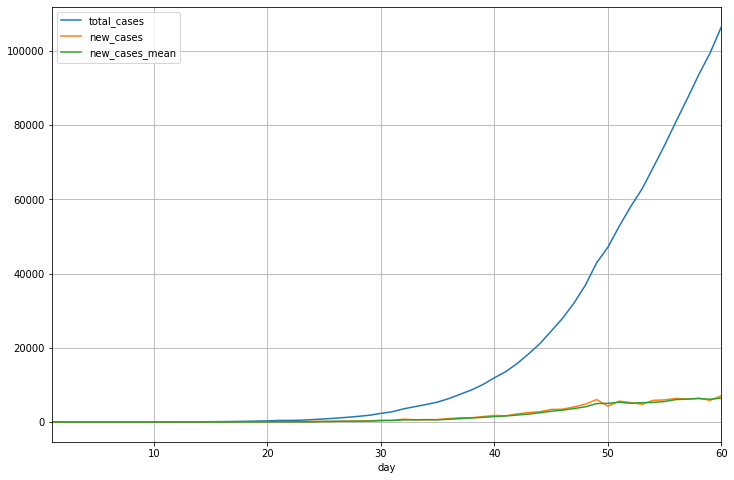

In [3]:
train_data.plot('day', ['total_cases', 'new_cases', 'new_cases_mean'], figsize=(12,8), grid=True, kind='line')

In [47]:
def train_linear_regression(train_data, test_data, target):
    model = linear_model.LinearRegression(fit_intercept=True).fit(train_data[['day']], train_data[target].map(np.log))
    sigma_noise = np.std(model.predict(train_data[['day']]) - train_data[target].map(np.log))
    train_score = metrics.r2_score(train_data[target], np.exp(model.predict(train_data[['day']])))
    test_score = metrics.r2_score(test_data[target], np.exp(model.predict(test_data[['day']])))
    print(f'trainded model for {target}: ({model.coef_[0]}, {model.intercept_})\ntrain score: {train_score}, test score: {test_score}, sigma_noise: {sigma_noise}\n')
    return model, sigma_noise

model_total_cases, sigma_noise_total = train_linear_regression(train_data, test_data, 'total_cases')
model_new_cases, sigma_noise_new = train_linear_regression(train_data, test_data, 'new_cases_mean')

trainded model for total_cases: (0.1844705601868421, 1.630605568017626)
train score: -1.2591088800114498, test score: -1092.0392401341655, sigma_noise: 0.511933435879593

trainded model for new_cases_mean: (0.16433346985890143, 0.26550881180829844)
train score: -2.069738162982517, test score: -2799.71632756985, sigma_noise: 0.606993413218203



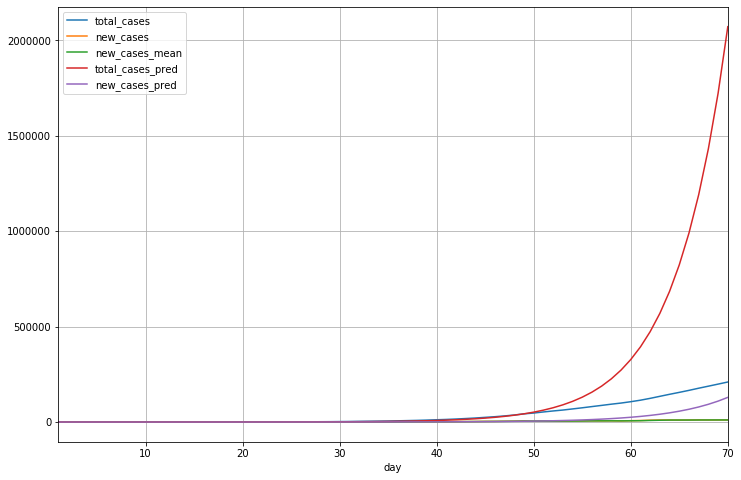

In [48]:
df['total_cases_pred'] = np.exp(model_total_cases.predict(df[['day']]))
df['new_cases_pred'] = np.exp(model_new_cases.predict(df[['day']]))

df.plot('day', ['total_cases', 'new_cases', 'new_cases_mean', 'total_cases_pred', 'new_cases_pred'], 
        figsize=(12,8), grid=True, kind='line')

В качестве априорного распределения модели выберем самый простой случай - стандартное нормальное распределение. Апостариорное распределение посчитаем по формулам из лекции.

In [52]:
def get_posteriour_model_params(model, train_data, target, sigma_noise):  
    # Априорное распределение возьмем самое простое стандартное нормальное распределение
    mu_prior, sigma_prior = np.array([0, 0]), np.array([[1, 0], [0, 1]])

    X = np.stack([np.array(train_data['day']), np.repeat(1., train_data.shape[0])], axis=-1)
    y = np.array(train_data[target].map(np.log))
    sigma_posteriour = np.linalg.inv(np.linalg.inv(sigma_prior) + (1 / (sigma_noise ** 2)) * np.matmul(X.T, X))
    mu_posteriour = np.matmul(sigma_posteriour, np.matmul(np.linalg.inv(sigma_prior), np.transpose(mu_prior)) + (1 / (sigma_noise ** 2)) * np.matmul(X.T, y))

    print(f'{target}: mu_posteriour = {mu_posteriour}, sigma_posteriour = {sigma_posteriour}\n')
    return mu_posteriour, sigma_posteriour

In [53]:
mu_total, sigma_total = get_posteriour_model_params(model_total_cases, train_data, 'total_cases', sigma_noise_total)
mu_new, sigma_new = get_posteriour_model_params(model_new_cases, train_data, 'new_cases_mean', sigma_noise_new)

total_cases: mu_posteriour = [0.18517946 1.60198676], sigma_posteriour = [[ 1.43697704e-05 -4.36371956e-04]
 [-4.36371956e-04  1.76003981e-02]]

new_cases_mean: mu_posteriour = [0.16449189 0.25908588], sigma_posteriour = [[ 2.00938386e-05 -6.09121654e-04]
 [-6.09121654e-04  2.45680294e-02]]



In [54]:
def plot_exp(w, train_data, target):
    fig = plt.figure(figsize = (15,8))
    ax = fig.add_subplot(111)
    ax.set_ylim((0, train_data[target].max() * 1.5))
    x = train_data[['day']]
    for w_ in w:
        y = np.exp(w_[0] * x + w_[1])
        plt.plot(x, y, color="0.3", linewidth=0.3)
    plt.plot(x, train_data[target], color='blue', lw=2, label='true values')
    plt.grid(True)
    plt.ylabel(target)
    plt.xlabel('day')
    plt.legend(loc="lower right")

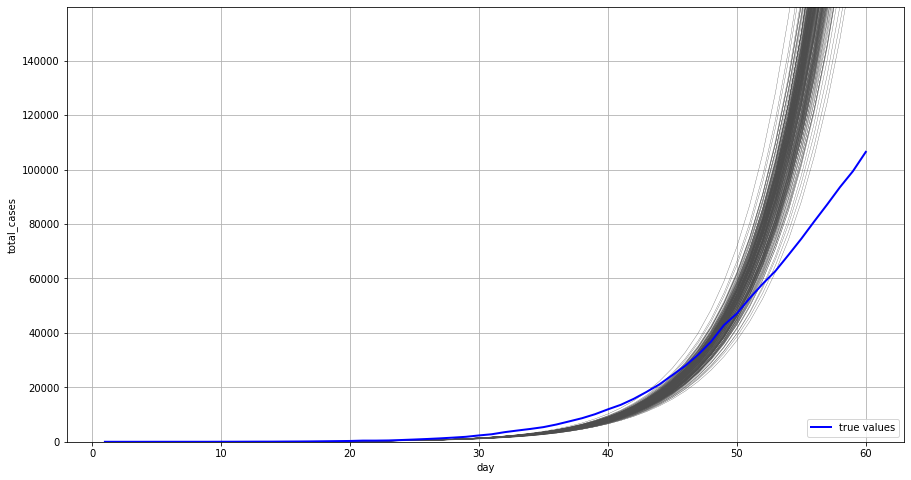

In [55]:
plot_exp(np.random.multivariate_normal(mu_total, sigma_total, 200), train_data, 'total_cases')

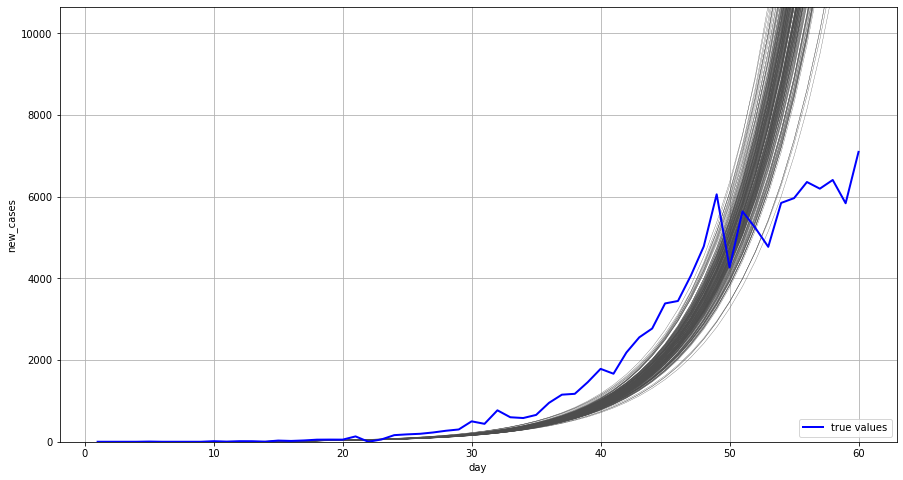

In [56]:
plot_exp(np.random.multivariate_normal(mu_new, sigma_new, 200), train_data, 'new_cases')

Предстказания получились плохие даже на тренеровочном сете, к последнему дню экспонента слишком завышает реальные данные.

In [57]:
def predict_target_distribution(mu, sigma, day, target, n=10000):
    w = np.random.multivariate_normal(mu, sigma, n)
    y = np.exp(w[:,0] * day + w[:,1])
    plt.figure(figsize = (8,4))
    plt.hist(y, bins=100, density=True)
    plt.grid(True)
    plt.xlabel('n cases')
    plt.title(f'{target} disctribution')
    y.sort()
    ci = y[int(0.5 * n)], y[int(0.1 * n)], y[int(0.9 * n)]
    print(f'Prediction on day {day} for {target} is {ci[0]:.0f} cases with best case scenario of {ci[1]:.0f} cases, and worst case of {ci[2]:.0f} cases')

In [58]:
import datetime

may_1 = (datetime.date(2020, 5, 1) - datetime.date(2020, 3, 3)).days + 1
june_1 = (datetime.date(2020, 6, 1) - datetime.date(2020, 3, 3)).days + 1
sept_1 = (datetime.date(2020, 9, 1) - datetime.date(2020, 3, 3)).days + 1

Prediction on day 60 for total_cases is 331332 cases with best case scenario of 280237 cases, and worst case of 390414 cases


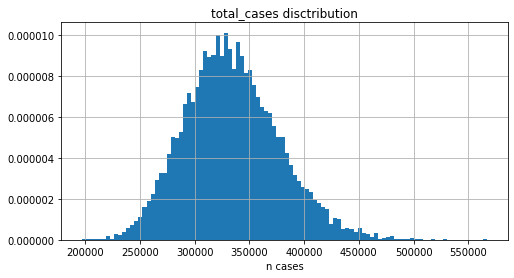

In [59]:
predict_target_distribution(mu_total, sigma_total, may_1, 'total_cases')

Prediction on day 60 for new_cases is 24992 cases with best case scenario of 20501 cases, and worst case of 30581 cases


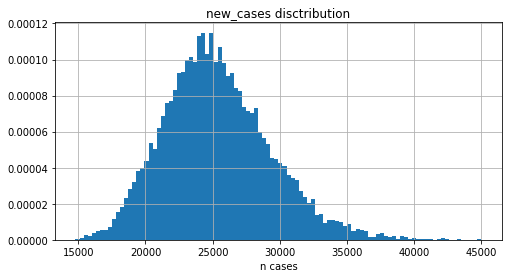

In [60]:
predict_target_distribution(mu_new, sigma_new, may_1, 'new_cases')

Prediction on day 91 for total_cases is 103326462 cases with best case scenario of 75945808 cases, and worst case of 140154883 cases


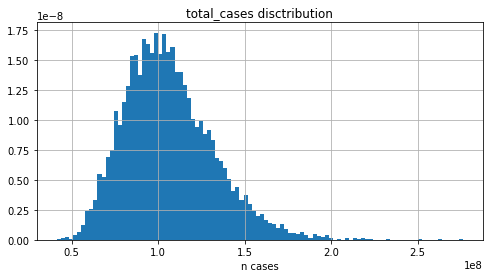

In [61]:
predict_target_distribution(mu_total, sigma_total, june_1, 'total_cases')

Prediction on day 91 for new_cases is 4097560 cases with best case scenario of 2866625 cases, and worst case of 5899475 cases


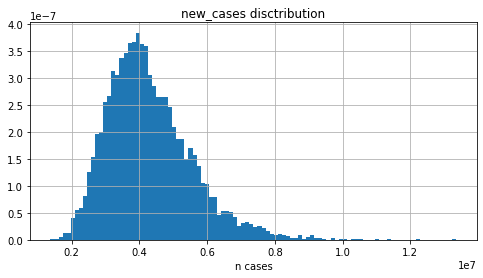

In [62]:
predict_target_distribution(mu_new, sigma_new, june_1, 'new_cases')

Prediction on day 183 for total_cases is 2600894039407812 cases with best case scenario of 1229962976781619 cases, and worst case of 5516245016658852 cases


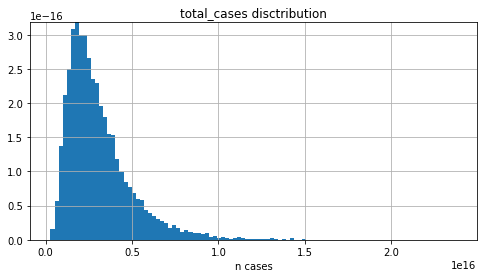

In [63]:
predict_target_distribution(mu_total, sigma_total, sept_1, 'total_cases')

Prediction on day 183 for new_cases is 15247719978639 cases with best case scenario of 6333069100781 cases, and worst case of 37255560966501 cases


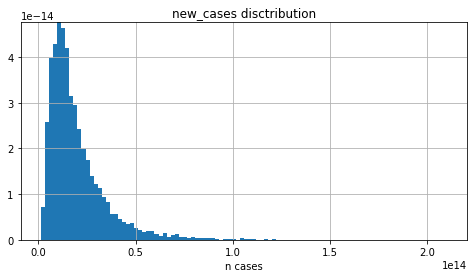

In [64]:
predict_target_distribution(mu_new, sigma_new, sept_1, 'new_cases')

In [65]:
import scipy.integrate as integrate
import scipy.special as special

Пусть 
$$\Phi(x) = \int_{-\infty}^{x}e^{w_2 t^2 + w_1 t + w_0}dt$$
тогда по свойствам интеграла, мы можем записать:
$$\frac{d\Phi(x)}{dx} = e^{w_2 x^2 + w_1 x + w_0}$$
или:
$$ln(\frac{d\Phi(x)}{dx}) = w_2 x^2 + w_1 x + w_0$$
справа мы получили линейную функцию, которую и хотели бы обучить с помощью линейной регрессии, остается как то посчитать левую часть.
Заметим что $\Phi(x)$ это и есть наш $y$, производную в точке $x_n$ мы можем оценить просто по выражению $\frac{y_{n+1} - 2 y_n + y_{n-1}}{2}$ ну и остается только взять логарифм, это и будет наш таргет для обучения.

In [69]:
from functools import partial

def phi(model, x):
    w = np.array([model.coef_[0], model.coef_[1], model.intercept_])
    return integrate.quad(lambda t: np.exp(model.predict(np.array([[t**2, t, 1]]))), -1000, x)[0]

def transform_y(df, target):
    dt = df.iloc[1].day - df.iloc[0].day
    y = np.array((df[target].diff(1) - df[target].diff(-1)) / (2 * dt))
    y[-1] = df[target].diff(1).iloc[-1]
    y = np.log(y)
    y[(y <= 1.) | np.isnan(y) | np.isinf(y)] = 1.
    return y

def train_sigmoid_regression(train_data, test_data, target):
    y = transform_y(train_data, target)
    X = np.stack([train_data.day ** 2, train_data.day, np.repeat(1, train_data.shape[0])], axis=1)
    model = linear_model.LinearRegression(fit_intercept=True).fit(X, y)
    sigma_noise = np.std(model.predict(X) - y)
    train_score = metrics.r2_score(train_data[target], train_data['day'].map(partial(phi, model)))
    test_score = metrics.r2_score(test_data[target], test_data['day'].map(partial(phi, model)))
    print(f'trainded model for {target}: ({model.coef_[0]}, {model.coef_[1]}, {model.intercept_})\ntrain score: {train_score}, test score: {test_score}\n, sigma_noise: {sigma_noise}')
    return model, sigma_noise

model_total_cases, sigma_noise_total = train_sigmoid_regression(train_data, test_data, 'total_cases')
model_new_cases, sigma_noise_new = train_sigmoid_regression(train_data[5:], test_data, 'new_cases_mean')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0016620198405492776, 0.25443689637067746, -0.1536661053599273)
train score: 0.9893096778892273, test score: 0.9459042800019758
, sigma_noise: 0.3155435968191688


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for new_cases_mean: (-0.002813403759105411, 0.27040243230897254, -1.6160728660443575)
train score: 0.6591026509647793, test score: -22.106302709595543
, sigma_noise: 1.171743839519238


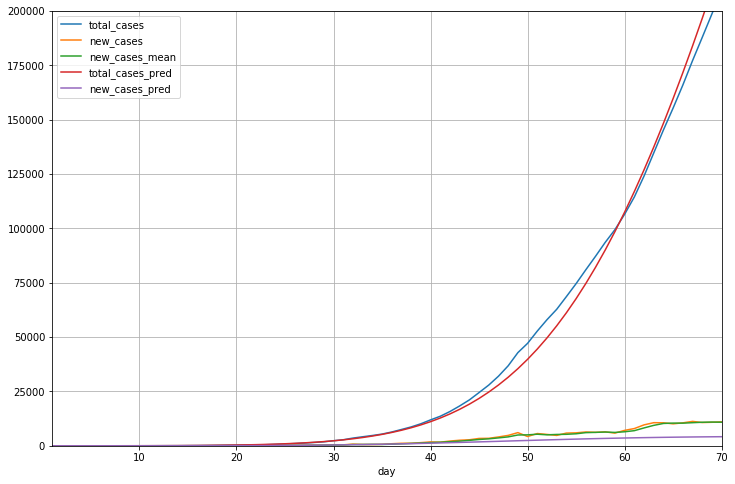

In [70]:
df['total_cases_pred'] = df['day'].map(partial(phi, model_total_cases))
df['new_cases_pred'] = df['day'].map(partial(phi, model_new_cases))

df.plot('day', ['total_cases', 'new_cases', 'new_cases_mean', 'total_cases_pred', 'new_cases_pred'], 
        figsize=(12,8), grid=True, kind='line', ylim=(0, 200000))

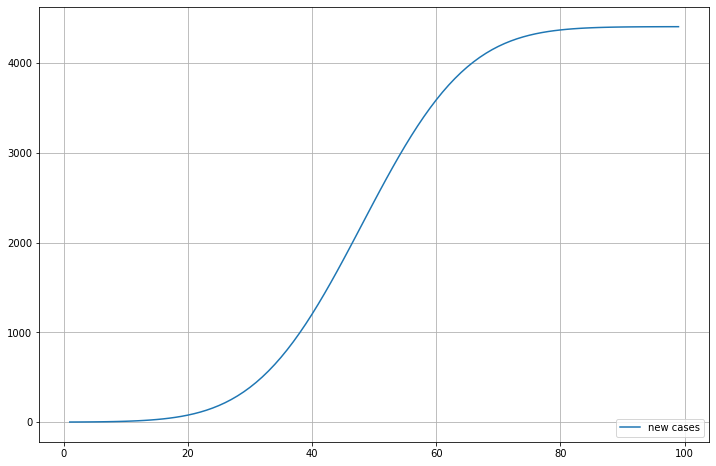

In [72]:
days = np.arange(1, 100)
plt.figure(figsize = (12,8))
plt.grid(True)
plt.plot(days, list(map(partial(phi, model_new_cases), days)), label='new cases')
plt.legend(loc="lower right")

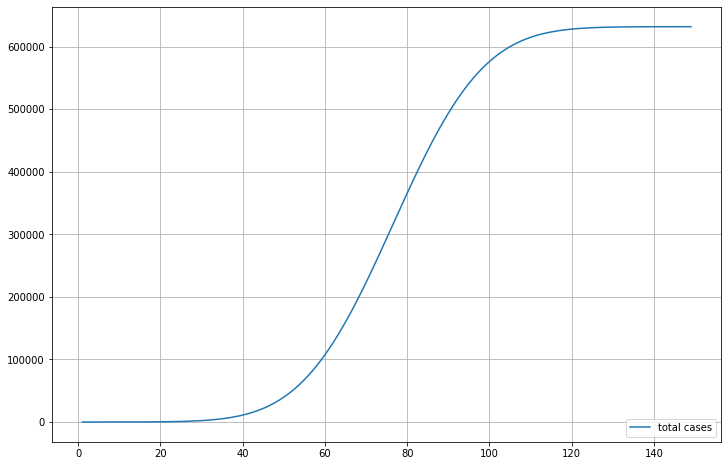

In [73]:
days = np.arange(1, 150)
plt.figure(figsize = (12,8))
plt.grid(True)
plt.plot(days, list(map(partial(phi, model_total_cases), days)), label='total cases')
plt.legend(loc="lower right")

In [77]:
def get_posteriour_sigm_model_params(model, train_data, target, sigma_noise):
    # Априорное распределение возьмем самое простое стандартное нормальное распределение
    mu_prior, sigma_prior = np.array([0, 0, 0]), np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

    X = np.stack([np.array(train_data['day']) ** 2, np.array(train_data['day']), np.repeat(1., train_data.shape[0])], axis=-1)
    y = transform_y(train_data, target)
    sigma_posteriour = np.linalg.inv(np.linalg.inv(sigma_prior) + (1 / (sigma_noise ** 2)) * np.matmul(X.T, X))
    mu_posteriour = np.matmul(sigma_posteriour, np.matmul(np.linalg.inv(sigma_prior), np.transpose(mu_prior)) + (1 / (sigma_noise ** 2)) * np.matmul(X.T, y))

    print(f'{target}: mu_posteriour = {mu_posteriour}, sigma_posteriour = {sigma_posteriour}\n')
    return mu_posteriour, sigma_posteriour

In [78]:
mu_total, sigma_total = get_posteriour_sigm_model_params(model_total_cases, train_data, 'total_cases', sigma_noise_total)
mu_new, sigma_new = get_posteriour_sigm_model_params(model_new_cases, train_data, 'new_cases_mean', sigma_noise_new)

total_cases: mu_posteriour = [-0.00165947  0.25425418 -0.15098527], sigma_posteriour = [[ 2.28698801e-08 -1.39263870e-06  1.43179560e-05]
 [-1.39263870e-06  9.03081162e-05 -1.03949484e-03]
 [ 1.43179560e-05 -1.03949484e-03  1.57244887e-02]]

new_cases_mean: mu_posteriour = [-0.00173755  0.1898429  -0.32213056], sigma_posteriour = [[ 2.84993582e-07 -1.70012250e-05  1.64190574e-04]
 [-1.70012250e-05  1.08554636e-03 -1.19220115e-02]
 [ 1.64190574e-04 -1.19220115e-02  1.80394658e-01]]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [79]:
def plot_sigmoid(w, train_data, target):
    fig = plt.figure(figsize = (15,8))
    ax = fig.add_subplot(111)
#     ax.set_ylim((0, train_data[target].max() * 1.1))
    x = np.arange(1, 150)
    for w_ in w:
        y = list(map(lambda d: integrate.quad(lambda t: np.exp(w_[0] * t**2 + w_[1] * t + w_[2]), -1000, d)[0], x))
        plt.plot(x, y, color="0.3", linewidth=0.3)
    plt.plot(train_data['day'], train_data[target], color='blue', lw=2, label='true values')
    plt.grid(True)
    plt.ylabel(target)
    plt.xlabel('day')
    plt.legend(loc="lower right")

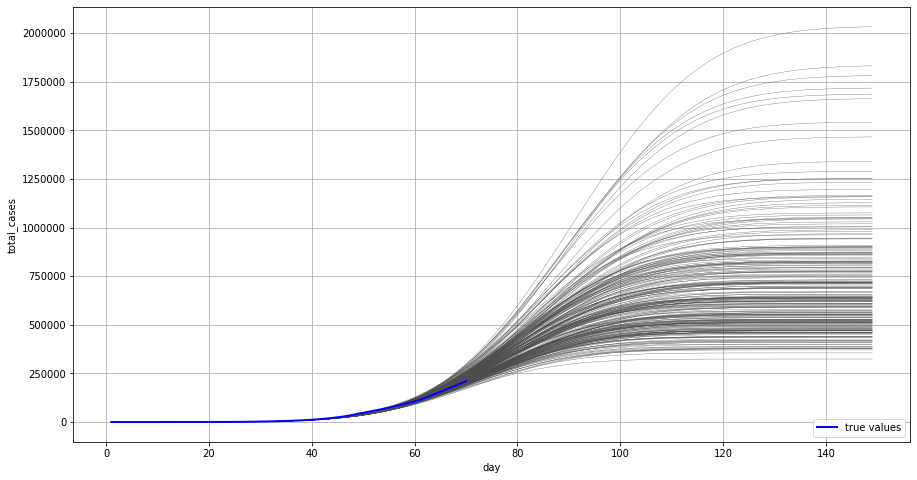

In [82]:
w = np.random.multivariate_normal(mu_total, sigma_total, 250)
plot_sigmoid(w, df, 'total_cases')

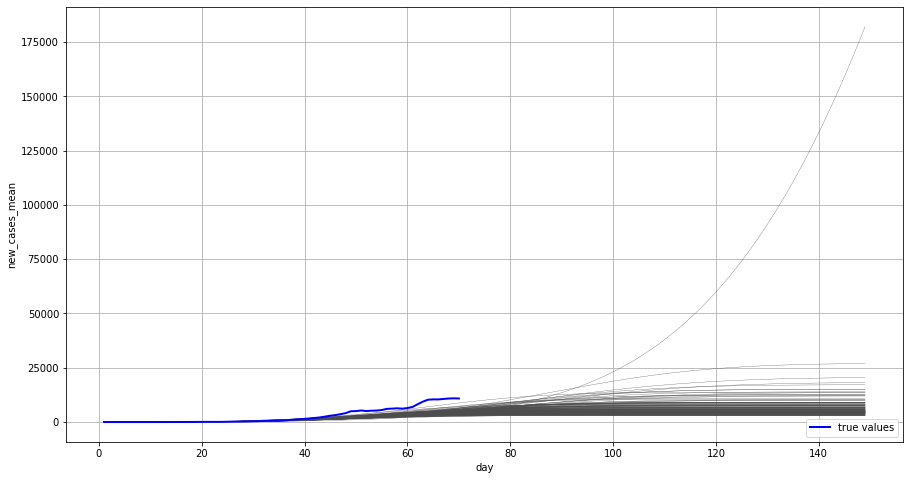

In [84]:
w = np.random.multivariate_normal(mu_new, sigma_new, 150)
plot_sigmoid(w, df, 'new_cases_mean')

In [85]:
def predict_target_distribution(mu, sigma, day, target, n=10000):
    w = np.random.multivariate_normal(mu, sigma, n)
    
    y = []
    for w_ in w:
        if w_[0] >= 0:
            continue
        pred = integrate.quad(lambda t: np.exp(w_[0] * (t ** 2) + w_[1] * t + w_[2]), -1000, day)[0]
        y.append(pred)
        
    y.sort()
    n = len(y)
    ci = y[int(0.5 * n)], y[int(0.1 * n)], y[int(0.9 * n)]

    plt.figure(figsize = (8,4))
    plt.hist(y, bins=100, density=True)
    plt.grid(True)
    plt.xlabel('n cases')
    plt.title(f'{target} disctribution')
    
    print(f'Prediction on day {day} for {target} is {ci[0]:.0f} cases with best case scenario of {ci[1]:.0f} cases, and worst case of {ci[2]:.0f} cases')

Prediction on day 60 for total_cases is 107594 cases with best case scenario of 98477 cases, and worst case of 117266 cases


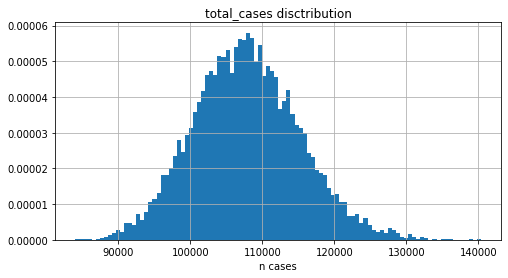

In [86]:
predict_target_distribution(mu_total, sigma_total, may_1, 'total_cases')

Prediction on day 60 for new_cases is 3479 cases with best case scenario of 2721 cases, and worst case of 4464 cases


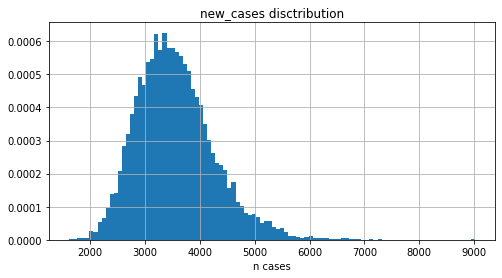

In [87]:
predict_target_distribution(mu_new, sigma_new, may_1, 'new_cases')

Prediction on day 91 for total_cases is 506618 cases with best case scenario of 374624 cases, and worst case of 710077 cases


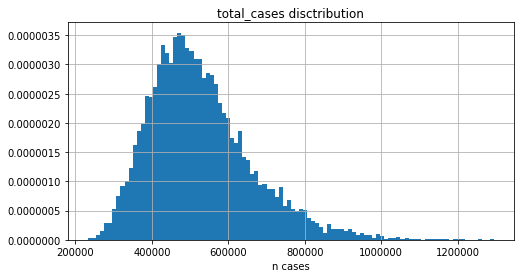

In [88]:
predict_target_distribution(mu_total, sigma_total, june_1, 'total_cases')

Prediction on day 91 for new_cases is 5539 cases with best case scenario of 3738 cases, and worst case of 10526 cases


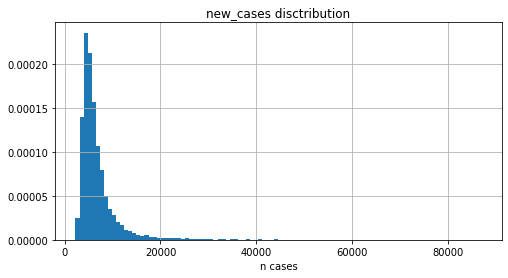

In [89]:
predict_target_distribution(mu_new, sigma_new, june_1, 'new_cases')

Prediction on day 183 for total_cases is 634866 cases with best case scenario of 432862 cases, and worst case of 1047973 cases


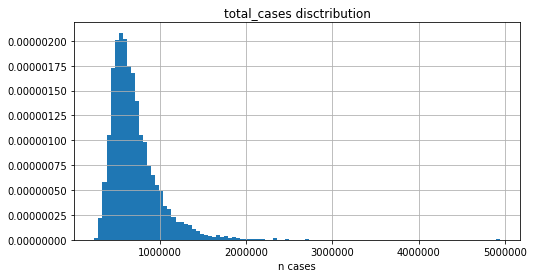

In [90]:
predict_target_distribution(mu_total, sigma_total, sept_1, 'total_cases')

Prediction on day 183 for new_cases is 5704 cases with best case scenario of 3780 cases, and worst case of 12643 cases


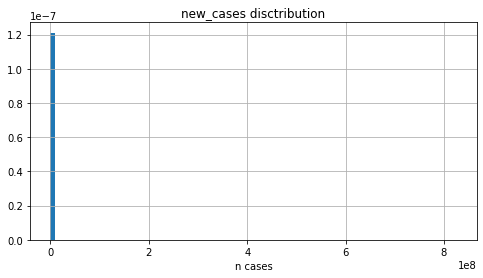

In [91]:
predict_target_distribution(mu_new, sigma_new, sept_1, 'new_cases')

Prediction on day 300 for total_cases is 632085 cases with best case scenario of 428647 cases, and worst case of 1042005 cases


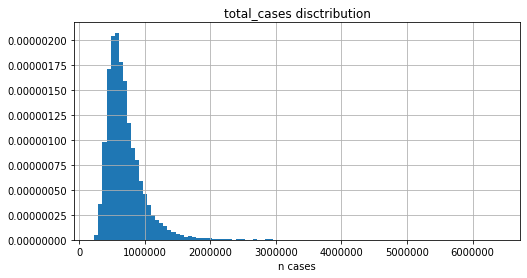

In [92]:
predict_target_distribution(mu_total, sigma_total, 300, 'total_cases')

В конечном итоге по прогнозу модели будет от 400к до 1 млн кейсов в России

Главное, что видно по данным распределениям, особенно по графику с семплом сигмоид по total_cases - то что незначительные калебания параметров модели в начале приводят к резуальтатам по итогу, которые могут отличаться на порядок. Это я еще взял 60 дней, поэтому модель получилась более устойчива. В конечном итоге, если бы мы просто зафитили регрессиию и выдали результат, то мы бы получили какое то предсказание. Но проведя полноценный анализ с помощью теоремы Байесса, мы теперь видим, что дисперсия конечного результата просто огромна, поэтому делать какие бы то нибыло предстказания практически невозможно.
Тем не менее, можно накапливать результаты наблюдений и получать все более и более устойчивые результаты.
Модель по новым кейсам очевидно вообще не подходит для данных - так как они должны затухать к концу, а не стабилизироваться на какой то отметке.

In [104]:
locations = pd.read_csv('Downloads/owid-covid-data.csv')['location'].unique()
dates = df[df.total_cases > 5].groupby(['location']).date.min()

In [108]:
data = dict([(loc, get_data(loc, TRAIN_DATA_DAYS, dates[loc])) for loc in locations if loc in dates])

In [109]:
data.keys()

dict_keys(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Andorra', 'United Arab Emirates', 'Argentina', 'Armenia', 'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana', 'Central African Republic', 'Canada', 'Switzerland', 'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros', 'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands', 'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt', 'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'Falkland Islands', 'France', 'Faeroe Islands', 'Gabon', 'United Kingdom', 'Georgia', 'Guernsey', 'Ghana', 'Gibraltar', 'Guinea', 'Gamb

In [116]:
# Обучим то, что обучится
result = dict()
for loc in data.keys():
    try:
        print(loc)
        tdf = data[loc][0][:TRAIN_DATA_DAYS]
        tdf['day'] = np.arange(1, tdf.shape[0] + 1)
        model, sigm = train_sigmoid_regression(tdf, tdf, 'total_cases')
        if model.coef_[0] < 0:
            result[loc] = get_posteriour_sigm_model_params(model, tdf, 'total_cases', sigm)
    except:
        pass

Aruba


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.00034438471689272274, -0.02887621000940366, 1.5862022918494576)
train score: -inf, test score: -inf
, sigma_noise: 0.2899005917478564
Afghanistan
trainded model for total_cases: (-0.0006251652291707738, 0.11680935395569902, 0.8451507474969588)
train score: 0.9974596393475397, test score: 0.9974596393475397
, sigma_noise: 0.33866563762193636
total_cases: mu_posteriour = [-6.39597899e-04  1.17841388e-01  8.29751594e-01], sigma_posteriour = [[ 2.86103076e-08 -1.71312515e-06  1.73138308e-05]
 [-1.71312515e-06  1.09241527e-04 -1.23622369e-03]
 [ 1.73138308e-05 -1.23622369e-03  1.83914727e-02]]

Angola


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.00012774745485125087, -0.0037468370395683675, 1.0285474727245911)
train score: -1.928296359591271e+114, test score: -1.928296359591271e+114
, sigma_noise: 0.0742125389969057
Albania


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0013347784535060372, 0.0944109506008471, 1.258234618356934)
train score: 0.9930501646170778, test score: 0.9930501646170778
, sigma_noise: 0.39712687885128084
total_cases: mu_posteriour = [-0.00136285  0.09645027  1.22733656], sigma_posteriour = [[ 3.60349472e-08 -2.19210592e-06  2.24711742e-05]
 [-2.19210592e-06  1.42045214e-04 -1.63143516e-03]
 [ 2.24711742e-05 -1.63143516e-03  2.46791100e-02]]

Andorra


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0012376746456806335, 0.022681194189353403, 2.8873623111862106)
train score: -0.016489256087720783, test score: -0.016489256087720783
, sigma_noise: 0.5090568968535275
total_cases: mu_posteriour = [-1.36670548e-03  3.14305707e-02  2.76373057e+00], sigma_posteriour = [[ 8.27183900e-08 -4.69228720e-06  4.47250294e-05]
 [-4.69228720e-06  2.83637356e-04 -3.03246168e-03]
 [ 4.47250294e-05 -3.03246168e-03  4.28420688e-02]]

United Arab Emirates
Argentina


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow e

trainded model for total_cases: (-0.0018727342530459638, 0.16353605884433295, 1.4467357197736979)
train score: 0.9858167052503061, test score: 0.9858167052503061
, sigma_noise: 0.4009131652995842
total_cases: mu_posteriour = [-0.00190549  0.16591672  1.4106366 ], sigma_posteriour = [[ 3.67154025e-08 -2.23338355e-06  2.28908128e-05]
 [-2.23338355e-06  1.44714360e-04 -1.66190199e-03]
 [ 2.28908128e-05 -1.66190199e-03  2.51400054e-02]]

Armenia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.000168538827858967, 0.04774421678620922, 2.5243324513858774)
train score: 0.96528275392627, test score: 0.96528275392627
, sigma_noise: 0.4435318783410655
total_cases: mu_posteriour = [-2.38732766e-04  5.28414242e-02  2.44719431e+00], sigma_posteriour = [[ 4.47921535e-08 -2.72300291e-06  2.78584358e-05]
 [-2.72300291e-06  1.76358831e-04 -2.02256560e-03]
 [ 2.78584358e-05 -2.02256560e-03  3.05960926e-02]]

Antigua and Barbuda


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (1.561052731136414e-05, -0.0017519673999430666, 1.0424841590665965)
train score: -2.2558421370245808e+17, test score: -2.2558421370245808e+17
, sigma_noise: 0.05759403889056425
Australia
Austria


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow e

trainded model for total_cases: (-0.0048727756117553115, 0.3274951452537334, 0.8110537774342061)
train score: 0.916947746591757, test score: 0.916947746591757
, sigma_noise: 0.514904685029207
total_cases: mu_posteriour = [-0.00490171  0.32960534  0.77884671], sigma_posteriour = [[ 6.00045690e-08 -3.64353194e-06  3.71479549e-05]
 [-3.64353194e-06  2.35773383e-04 -2.69701911e-03]
 [ 3.71479549e-05 -2.69701911e-03  4.07994038e-02]]

Azerbaijan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.002046012809490901, 0.17207072357516925, 0.4943061855705997)
train score: 0.9615958540791781, test score: 0.9615958540791781
, sigma_noise: 0.4406048087412376
total_cases: mu_posteriour = [-0.00205915  0.17302778  0.47971891], sigma_posteriour = [[ 4.42130724e-08 -2.68791885e-06  2.75030896e-05]
 [-2.68791885e-06  1.74092300e-04 -1.99676636e-03]
 [ 2.75030896e-05 -1.99676636e-03  3.02058010e-02]]

Burundi
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -313842.1041009345, test score: -313842.1041009345
, sigma_noise: 0.0
Belgium


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.003417608883808406, 0.27356927394230646, 1.9689826260582066)
train score: 0.9955368938697201, test score: 0.9955368938697201
, sigma_noise: 0.33630297224733946
total_cases: mu_posteriour = [-0.00344913  0.27586118  1.93421125], sigma_posteriour = [[ 2.59461714e-08 -1.57959553e-06  1.62289569e-05]
 [-1.57959553e-06  1.02413884e-04 -1.17823673e-03]
 [ 1.62289569e-05 -1.17823673e-03  1.78232964e-02]]

Benin
Bonaire Sint Eustatius and Saba
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: 0.0, test score: 0.0
, sigma_noise: 0.0
Burkina Faso


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  ""

trainded model for total_cases: (-0.0012489347466482863, 0.055692731192461487, 2.0849096915863745)
train score: 0.9540144554381618, test score: 0.9540144554381618
, sigma_noise: 0.6349522872717522
total_cases: mu_posteriour = [-1.39020907e-03  6.52746372e-02  1.94944857e+00], sigma_posteriour = [[ 1.26984148e-07 -7.18452962e-06  6.79523977e-05]
 [-7.18452962e-06  4.33445020e-04 -4.60742003e-03]
 [ 6.79523977e-05 -4.60742003e-03  6.50952916e-02]]

Bangladesh


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.001394342665627001, 0.209001291640802, -0.17907656443056919)
train score: 0.948312536593857, test score: 0.948312536593857
, sigma_noise: 0.7176254241996379
total_cases: mu_posteriour = [-0.0013762   0.20780825 -0.16293809], sigma_posteriour = [[ 1.75563115e-07 -9.73761388e-06  8.99277735e-05]
 [-9.73761388e-06  5.76209801e-04 -5.98962328e-03]
 [ 8.99277735e-05 -5.98962328e-03  8.31292932e-02]]

Bulgaria


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0003521039280189095, 0.049245408423397107, 2.2427468140623827)
train score: 0.9593703002610089, test score: 0.9593703002610089
, sigma_noise: 0.3990257610243391
total_cases: mu_posteriour = [-4.02863095e-04  5.29314381e-02  2.18696162e+00], sigma_posteriour = [[ 3.63754447e-08 -2.21276165e-06  2.26811817e-05]
 [-2.21276165e-06  1.43380906e-04 -1.64668224e-03]
 [ 2.26811817e-05 -1.64668224e-03  2.49097643e-02]]

Bahrain


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0003681884723578141, 0.08186788088366416, 1.1061604927788555)
train score: 0.9575811532664875, test score: 0.9575811532664875
, sigma_noise: 0.5857487647223841
total_cases: mu_posteriour = [-4.20347758e-04  8.56578328e-02  1.04873453e+00], sigma_posteriour = [[ 7.71281708e-08 -4.67710687e-06  4.74996346e-05]
 [-4.67710687e-06  3.02358792e-04 -3.44860184e-03]
 [ 4.74996346e-05 -3.44860184e-03  5.21699228e-02]]

Bahamas


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (1.0631247019292098e-05, -0.00095427979142252, 1.0726463375296973)
train score: -307124084260.5052, test score: -307124084260.5052
, sigma_noise: 0.1242513167502934
Bosnia and Herzegovina


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0018805234138416338, 0.12627260891936953, 1.8368548725130878)
train score: 0.9791092946972425, test score: 0.9791092946972425
, sigma_noise: 0.5084543189989257
total_cases: mu_posteriour = [-0.00195769  0.13160137  1.76012072], sigma_posteriour = [[ 7.55700665e-08 -4.36243025e-06  4.23098553e-05]
 [-4.36243025e-06  2.68354659e-04 -2.91947541e-03]
 [ 4.23098553e-05 -2.91947541e-03  4.19754897e-02]]

Belarus


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0012283337478788828, 0.19196460476097088, 0.15385692679972518)
train score: 0.8873986822427116, test score: 0.8873986822427116
, sigma_noise: 1.0098174995809839
total_cases: mu_posteriour = [-0.00124552  0.19323337  0.13401823], sigma_posteriour = [[ 2.17129168e-07 -1.30230434e-05  1.27923630e-04]
 [-1.30230434e-05  8.34972336e-04 -9.28828311e-03]
 [ 1.27923630e-04 -9.28828311e-03  1.40532352e-01]]

Belize
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -613302.0618323366, test score: -613302.0618323366
, sigma_noise: 0.0
Bermuda


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0005893284143846705, 0.026988071292101255, 1.015015129537059)
train score: -2.9336819717378724, test score: -2.9336819717378724
, sigma_noise: 0.3542792529024171
total_cases: mu_posteriour = [-6.20945702e-04  2.89047561e-02  9.90795938e-01], sigma_posteriour = [[ 7.14268830e-08 -3.63312275e-06  3.12462146e-05]
 [-3.63312275e-06  1.96758989e-04 -1.89356496e-03]
 [ 3.12462146e-05 -1.89356496e-03  2.39112831e-02]]

Bolivia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0002661943993534693, 0.08881965379782264, 0.8050419640833688)
train score: 0.9950347496277956, test score: 0.9950347496277956
, sigma_noise: 0.37573127119013144
total_cases: mu_posteriour = [-2.83985266e-04  9.00700982e-02  7.86707374e-01], sigma_posteriour = [[ 3.82569414e-08 -2.25141419e-06  2.23477124e-05]
 [-2.25141419e-06  1.41115479e-04 -1.56883599e-03]
 [ 2.23477124e-05 -1.56883599e-03  2.29477972e-02]]

Brazil


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.00256755780390645, 0.2718161546998923, 1.1397165377419363)
train score: 0.9745432273493261, test score: 0.9745432273493261
, sigma_noise: 0.39432939699491837
total_cases: mu_posteriour = [-0.00259223  0.27361198  1.11241201], sigma_posteriour = [[ 3.55361117e-08 -2.16184292e-06  2.21634303e-05]
 [-2.16184292e-06  1.40088177e-04 -1.60909218e-03]
 [ 2.21634303e-05 -1.60909218e-03  2.43411107e-02]]

Barbados


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (5.690040230076319e-05, -0.009129449195335539, 1.2807329989679308)
train score: -3.503825853848362e+57, test score: -3.503825853848362e+57
, sigma_noise: 0.18894573635793455
Brunei


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = 

trainded model for total_cases: (0.0005653455914097869, -0.050015593233507204, 2.046797960421333)
train score: -inf, test score: -inf
, sigma_noise: 0.24098270199438068
Bhutan
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -26300206.39216839, test score: -26300206.39216839
, sigma_noise: 0.0
Botswana
trainded model for total_cases: (9.920346544129249e-05, -0.004956584576592254, 1.056799145117565)
train score: -1.8176685421826714e+91, test score: -1.8176685421826714e+91
, sigma_noise: 0.040982782953080346
Central African Republic
Canada
Switzerland


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  ""

trainded model for total_cases: (-0.0046308991313180154, 0.3287408534244385, 1.2064077832462132)
train score: 0.980836497350866, test score: 0.980836497350866
, sigma_noise: 0.4243001758778194
total_cases: mu_posteriour = [-0.00466092  0.33092655  1.1731499 ], sigma_posteriour = [[ 4.10529529e-08 -2.49640534e-06  2.55616906e-05]
 [-2.49640534e-06  1.61717312e-04 -1.85581498e-03]
 [ 2.55616906e-05 -1.85581498e-03  2.80734931e-02]]

Chile


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0020500989045364394, 0.1985547350865517, 1.8333833508207893)
train score: 0.95504110976138, test score: 0.95504110976138
, sigma_noise: 0.49109701580318854
total_cases: mu_posteriour = [-0.00211162  0.20302675  1.76557583], sigma_posteriour = [[ 5.46988992e-08 -3.32272355e-06  3.39179691e-05]
 [-3.32272355e-06  2.15079051e-04 -2.46250899e-03]
 [ 3.39179691e-05 -2.46250899e-03  3.72516370e-02]]

China


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.004561850928376818, 0.40537780807752855, -1.5029214906620387)
train score: 0.5637272508327935, test score: 0.5637272508327935
, sigma_noise: 1.2086533288374794
total_cases: mu_posteriour = [-0.00429503  0.38606785 -1.21267545], sigma_posteriour = [[ 3.01396780e-07 -1.79561642e-05  1.72690181e-04]
 [-1.79561642e-05  1.14536617e-03 -1.25392945e-02]
 [ 1.72690181e-04 -1.25392945e-02  1.89738522e-01]]

Cote d'Ivoire


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.001549497544967916, 0.1213220013417404, 1.4372190197029953)
train score: 0.9878209632144138, test score: 0.9878209632144138
, sigma_noise: 0.4864184780287966
total_cases: mu_posteriour = [-0.00161463  0.12558582  1.37899612], sigma_posteriour = [[ 9.07046919e-08 -4.96598286e-06  4.57350342e-05]
 [-4.96598286e-06  2.89677337e-04 -2.99117630e-03]
 [ 4.57350342e-05 -2.99117630e-03  4.07633562e-02]]

Cameroon


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0012899347291344346, 0.10437897168362403, 1.5659489468477974)
train score: 0.6250941045992401, test score: 0.6250941045992401
, sigma_noise: 1.2400398729481472
total_cases: mu_posteriour = [-0.00164767  0.1282318   1.23417735], sigma_posteriour = [[ 4.82594640e-07 -2.63072746e-05  2.30199680e-04]
 [-2.63072746e-05  1.53634561e-03 -1.53346131e-02]
 [ 2.30199680e-04 -1.53346131e-02  2.12888489e-01]]

Democratic Republic of Congo


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.00010664705568776462, 0.036029871505754686, 1.4738741163365816)
train score: -1.756222297510543e+59, test score: -1.756222297510543e+59
, sigma_noise: 0.5838155586560583
Congo


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0014156478347772188, 0.07320514954835566, 0.9763506857051188)
train score: 0.9615152557458657, test score: 0.9615152557458657
, sigma_noise: 0.6268383706715863
total_cases: mu_posteriour = [-0.00154728  0.08024303  0.89784644], sigma_posteriour = [[ 4.09418427e-07 -1.82531140e-05  1.36192050e-04]
 [-1.82531140e-05  8.67659632e-04 -7.27343530e-03]
 [ 1.36192050e-04 -7.27343530e-03  8.09513381e-02]]

Colombia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.001162285048598072, 0.13267640567772987, 2.0913445589588244)
train score: 0.9897057496856438, test score: 0.9897057496856438
, sigma_noise: 0.4072247609841396
total_cases: mu_posteriour = [-1.21133159e-03  1.36239635e-01  2.03737046e+00], sigma_posteriour = [[ 3.78632215e-08 -2.30300249e-06  2.35982805e-05]
 [-2.30300249e-06  1.49215676e-04 -1.71326599e-03]
 [ 2.35982805e-05 -1.71326599e-03  2.59170301e-02]]

Comoros
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -3418231.543762112, test score: -3418231.543762112
, sigma_noise: 0.0
Cape Verde


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


trainded model for total_cases: (0.00041507928138525836, 0.02358176824188045, 0.8977621081566123)
train score: -inf, test score: -inf
, sigma_noise: 0.5466967849462948
Costa Rica
trainded model for total_cases: (-0.0016657003556532566, 0.08923085063954692, 1.6222952912569162)
train score: 0.9497650740886234, test score: 0.9497650740886234
, sigma_noise: 0.5438328587411619
total_cases: mu_posteriour = [-0.00173225  0.09406523  1.54907565], sigma_posteriour = [[ 6.67575771e-08 -4.05147108e-06  4.12436224e-05]
 [-4.05147108e-06  2.62069763e-04 -2.99438306e-03]
 [ 4.12436224e-05 -2.99438306e-03  4.52981052e-02]]

Cuba


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0029573958904550077, 0.18926470182692545, 0.9920340075932512)
train score: 0.9991561002534194, test score: 0.9991561002534194
, sigma_noise: 0.22236640319990547
total_cases: mu_posteriour = [-0.00296648  0.1898708   0.98358666], sigma_posteriour = [[ 1.76249451e-08 -9.86060225e-07  9.34184459e-06]
 [-9.86060225e-07  5.87246043e-05 -6.22171174e-04]
 [ 9.34184459e-06 -6.22171174e-04  8.63391274e-03]]

Curacao
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -940262.2123071868, test score: -940262.2123071868
, sigma_noise: 0.0
Cayman Islands


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (1.8783805571092895e-05, -0.007420178159706301, 1.2529567808325808)
train score: -7.071262745082069e+23, test score: -7.071262745082069e+23
, sigma_noise: 0.17950755585009334
Cyprus


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.002049436906166253, 0.10911525742275736, 1.6220569626022519)
train score: 0.9571287562363787, test score: 0.9571287562363787
, sigma_noise: 0.43012873616140573
total_cases: mu_posteriour = [-0.00209173  0.11218822  1.57550496], sigma_posteriour = [[ 4.21698413e-08 -2.56410309e-06  2.62482743e-05]
 [-2.56410309e-06  1.66092238e-04 -1.90566296e-03]
 [ 2.62482743e-05 -1.90566296e-03  2.88275902e-02]]

Czech Republic


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0035564211803094377, 0.23819530909480702, 1.5630156548735368)
train score: 0.9730657532358552, test score: 0.9730657532358552
, sigma_noise: 0.4234868494193739
total_cases: mu_posteriour = [-0.00359563  0.24104679  1.51974018], sigma_posteriour = [[ 4.08982348e-08 -2.48702652e-06  2.54665438e-05]
 [-2.48702652e-06  1.61111167e-04 -1.84890705e-03]
 [ 2.54665438e-05 -1.84890705e-03  2.79689905e-02]]

Germany
Djibouti


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow e

trainded model for total_cases: (-0.004417208931673458, 0.2292972754876322, 0.496482590121444)
train score: 0.6734874972065119, test score: 0.6734874972065119
, sigma_noise: 0.8199345071678953
total_cases: mu_posteriour = [-0.00450202  0.23416694  0.43780619], sigma_posteriour = [[ 4.90615180e-07 -2.32089945e-05  1.81551402e-04]
 [-2.32089945e-05  1.17236974e-03 -1.03499907e-02]
 [ 1.81551402e-04 -1.03499907e-02  1.22965894e-01]]

Dominica
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -1705581.075084761, test score: -1705581.075084761
, sigma_noise: 0.0
Denmark


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.00228001283077966, 0.17603160767322096, 2.1721348077729)
train score: 0.981185543245542, test score: 0.981185543245542
, sigma_noise: 0.574562551524464
total_cases: mu_posteriour = [-0.00237869  0.1832021   2.0634704 ], sigma_posteriour = [[ 7.42935065e-08 -4.50619833e-06  4.57936952e-05]
 [-4.50619833e-06  2.91357678e-04 -3.32474135e-03]
 [ 4.57936952e-05 -3.32474135e-03  5.02960385e-02]]

Dominican Republic


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0022932803467650173, 0.20043044532927162, 1.4323485455615432)
train score: 0.9723570184982292, test score: 0.9723570184982292
, sigma_noise: 0.5924641920249613
total_cases: mu_posteriour = [-0.00236536  0.20558541  1.35541465], sigma_posteriour = [[ 8.57208802e-08 -5.11173485e-06  5.10405382e-05]
 [-5.11173485e-06  3.24969566e-04 -3.64444033e-03]
 [ 5.10405382e-05 -3.64444033e-03  5.42217700e-02]]

Algeria


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.001891043951980529, 0.1754628737300313, 0.9589412967745283)
train score: 0.980911119119089, test score: 0.980911119119089
, sigma_noise: 0.399043348947339
total_cases: mu_posteriour = [-0.00191241  0.17701692  0.93534124], sigma_posteriour = [[ 3.63786057e-08 -2.21295339e-06  2.26831311e-05]
 [-2.21295339e-06  1.43393305e-04 -1.64682377e-03]
 [ 2.26831311e-05 -1.64682377e-03  2.49119053e-02]]

Ecuador


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0020462946235874475, 0.21364762822224798, 0.9401056272024468)
train score: 0.7732039896368539, test score: 0.7732039896368539
, sigma_noise: 1.1481980924427617
total_cases: mu_posteriour = [-0.00219208  0.22426403  0.77854433], sigma_posteriour = [[ 2.74703464e-07 -1.64008573e-05  1.58805721e-04]
 [-1.64008573e-05  1.04787206e-03 -1.15309446e-02]
 [ 1.58805721e-04 -1.15309446e-02  1.74475270e-01]]

Egypt


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0008809775468427957, 0.12046434012914622, 1.636029193577344)
train score: 0.993325135659489, test score: 0.993325135659489
, sigma_noise: 0.4424225325386447
total_cases: mu_posteriour = [-9.26007573e-04  1.23736147e-01  1.58645802e+00], sigma_posteriour = [[ 4.45722643e-08 -2.70968112e-06  2.77235182e-05]
 [-2.70968112e-06  1.75498223e-04 -2.01277017e-03]
 [ 2.77235182e-05 -2.01277017e-03  3.04479070e-02]]

Eritrea


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (8.00444896749096e-05, -0.0058488204253233055, 1.1020506469080225)
train score: -1.3228856967674162e+75, test score: -1.3228856967674162e+75
, sigma_noise: 0.05787295221966945
Western Sahara
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: 0.0, test score: 0.0
, sigma_noise: 0.0
Spain


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.005030858497184112, 0.39686307764443074, 1.2413827292903896)
train score: 0.9891252051356549, test score: 0.9891252051356549
, sigma_noise: 0.4318178691629249
total_cases: mu_posteriour = [-0.00506267  0.39918037  1.20608545], sigma_posteriour = [[ 4.24961816e-08 -2.58388129e-06  2.64487962e-05]
 [-2.58388129e-06  1.67370285e-04 -1.92022145e-03]
 [ 2.64487962e-05 -1.92022145e-03  2.90478304e-02]]

Estonia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0028716275123532972, 0.1670433086075707, 1.4411422011062762)
train score: 0.9679071500959359, test score: 0.9679071500959359
, sigma_noise: 0.5136133933010183
total_cases: mu_posteriour = [-0.0029243   0.17087222  1.38307545], sigma_posteriour = [[ 5.97109300e-08 -3.62578392e-06  3.69694721e-05]
 [-3.62578392e-06  2.34628848e-04 -2.68406049e-03]
 [ 3.69694721e-05 -2.68406049e-03  4.06033594e-02]]

Ethiopia
Finland


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launc

trainded model for total_cases: (-0.0022928571347221923, 0.1944520148113168, 0.8878272584935258)
train score: 0.9941495534204275, test score: 0.9941495534204275
, sigma_noise: 0.483143996148497
total_cases: mu_posteriour = [-0.00232141  0.19653009  0.85624233], sigma_posteriour = [[ 5.29777718e-08 -3.21859845e-06  3.28678922e-05]
 [-3.21859845e-06  2.08359529e-04 -2.38626941e-03]
 [ 3.28678922e-05 -2.38626941e-03  3.60982610e-02]]

Fiji
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -1053506.932963802, test score: -1053506.932963802
, sigma_noise: 0.0
Falkland Islands
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -10165468.71530523, test score: -10165468.71530523
, sigma_noise: 0.0
France


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Faeroe Islands
Gabon


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value enco

trainded model for total_cases: (0.0004184057762873009, 0.03256841840072163, 0.8375725443320365)
train score: -inf, test score: -inf
, sigma_noise: 0.6763156134381993
United Kingdom
trainded model for total_cases: (0.0002532361562684962, 0.14942339758046147, -0.3318619354638557)
train score: -2.030827979537359e+82, test score: -2.030827979537359e+82
, sigma_noise: 0.6498753676613481
Georgia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0010113493032496705, 0.09058158120631246, 0.5201063407754212)
train score: 0.9772209837699088, test score: 0.9772209837699088
, sigma_noise: 0.46306638095527947
total_cases: mu_posteriour = [-0.00102683  0.09170769  0.50300755], sigma_posteriour = [[ 4.87479340e-08 -2.96258277e-06  3.02824662e-05]
 [-2.96258277e-06  1.91832330e-04 -2.19855819e-03]
 [ 3.02824662e-05 -2.19855819e-03  3.32585249e-02]]

Guernsey


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0008097643407452351, 0.0166736585992725, 1.7401481657881022)
train score: -0.21680614617571625, test score: -0.21680614617571625
, sigma_noise: 0.5425022908219871
total_cases: mu_posteriour = [-9.33112954e-04  2.41499119e-02  1.64571155e+00], sigma_posteriour = [[ 1.64461319e-07 -8.33614398e-06  7.09639229e-05]
 [-8.33614398e-06  4.50295840e-04 -4.30064994e-03]
 [ 7.09639229e-05 -4.30064994e-03  5.43105392e-02]]

Ghana


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.00038997746679918433, 0.09120551207682027, 1.1203037451778624)
train score: 0.7639204525592336, test score: 0.7639204525592336
, sigma_noise: 1.1270604129714974
total_cases: mu_posteriour = [-5.98282416e-04  1.05346411e-01  9.20034078e-01], sigma_posteriour = [[ 3.72351699e-07 -2.07579555e-05  1.87626200e-04]
 [-2.07579555e-05  1.23843787e-03 -1.27232095e-02]
 [ 1.87626200e-04 -1.27232095e-02  1.79799602e-01]]

Gibraltar


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-7.511820219275677e-05, -0.01078995982476637, 1.622009484327649)
train score: -756.4230152962592, test score: -756.4230152962592
, sigma_noise: 0.3924854944747403
total_cases: mu_posteriour = [-1.27010049e-04 -7.45868342e-03  1.57745199e+00], sigma_posteriour = [[ 6.53585646e-08 -3.51859749e-06  3.19689167e-05]
 [-3.51859749e-06  2.01734405e-04 -2.05245407e-03]
 [ 3.19689167e-05 -2.05245407e-03  2.74568963e-02]]

Guinea


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0025487974649222494, 0.17515360724312193, 1.343452882892079)
train score: 0.9939060020632424, test score: 0.9939060020632424
, sigma_noise: 0.4153228297130007
total_cases: mu_posteriour = [-0.00263154  0.17958045  1.29400595], sigma_posteriour = [[ 1.84605833e-07 -8.27278112e-06  6.26675061e-05]
 [-8.27278112e-06  3.94746818e-04 -3.34660234e-03]
 [ 6.26675061e-05 -3.34660234e-03  3.72422882e-02]]

Gambia
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -489705.2576938799, test score: -489705.2576938799
, sigma_noise: 0.0
Guinea-Bissau
Equatorial Guinea


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3

trainded model for total_cases: (-0.001098149066382838, 0.08240411445336343, 0.3950261294974564)
train score: 0.7077373217924805, test score: 0.7077373217924805
, sigma_noise: 0.9370439125239592
total_cases: mu_posteriour = [-0.0011676   0.08670939  0.33924213], sigma_posteriour = [[ 4.20441076e-07 -2.14887493e-05  1.80289753e-04]
 [-2.14887493e-05  1.17376058e-03 -1.11436284e-02]
 [ 1.80289753e-04 -1.11436284e-02  1.43541076e-01]]

Greece


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0025633538149393413, 0.16655483794960274, 1.495700505117357)
train score: 0.9513534112569813, test score: 0.9513534112569813
, sigma_noise: 0.6675691534194664
total_cases: mu_posteriour = [-0.00265321  0.17308645  1.39664545], sigma_posteriour = [[ 9.93096433e-08 -6.01185788e-06  6.07430848e-05]
 [-6.01185788e-06  3.88147696e-04 -4.41016118e-03]
 [ 6.07430848e-05 -4.41016118e-03  6.67177297e-02]]

Grenada
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -423466.88701930695, test score: -423466.88701930695
, sigma_noise: 0.0
Greenland


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -11006081.091288399, test score: -11006081.091288399
, sigma_noise: 0.0
Guatemala


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.00016991272537605074, 0.07258502456734288, 0.5777322407784031)
train score: 0.9888922815022441, test score: 0.9888922815022441
, sigma_noise: 0.3747487858442992
total_cases: mu_posteriour = [-1.84011165e-04  7.35422742e-02  5.64170475e-01], sigma_posteriour = [[ 4.53401753e-08 -2.57760051e-06  2.47269262e-05]
 [-2.57760051e-06  1.56062297e-04 -1.67651696e-03]
 [ 2.47269262e-05 -1.67651696e-03  2.36847789e-02]]

Guam


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (7.432746888655754e-06, -0.01553756814571067, 1.6597038477347439)
train score: -1.3855063696086406e+21, test score: -1.3855063696086406e+21
, sigma_noise: 0.35231791943241264
Guyana


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.00047413953409191175, -0.017904060023061944, 1.2315800455737895)
train score: -inf, test score: -inf
, sigma_noise: 0.23091858170295884
Honduras


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encou

trainded model for total_cases: (0.0006976934833073424, 0.014578892272265031, 1.7375129873423225)
train score: -inf, test score: -inf
, sigma_noise: 0.7177444101222494
Croatia
trainded model for total_cases: (-0.0032966971654728615, 0.23322025999027415, 0.03600847133058105)
train score: 0.9812475901241484, test score: 0.9812475901241484
, sigma_noise: 0.3705791209058659
total_cases: mu_posteriour = [-0.00329696  0.23324265  0.03556461], sigma_posteriour = [[ 3.14356890e-08 -1.91299328e-06  1.96302284e-05]
 [-1.91299328e-06  1.23991421e-04 -1.42517582e-03]
 [ 1.96302284e-05 -1.42517582e-03  2.15588802e-02]]

Haiti
Hungary


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launc

trainded model for total_cases: (-0.0023508332680742825, 0.19125300733813816, 0.6298318075904152)
train score: 0.9976572038254098, test score: 0.9976572038254098
, sigma_noise: 0.281161727270893
total_cases: mu_posteriour = [-0.0023578   0.19176076  0.6221014 ], sigma_posteriour = [[ 1.81915276e-08 -1.10815021e-06  1.14049441e-05]
 [-1.10815021e-06  7.18788988e-05 -8.28006043e-04]
 [ 1.14049441e-05 -8.28006043e-04  1.25252318e-02]]

Indonesia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.001695847248414198, 0.15595890679555308, 2.374033892089165)
train score: 0.9975204057014797, test score: 0.9975204057014797
, sigma_noise: 0.3197524698180836
total_cases: mu_posteriour = [-1.73051356e-03  1.58477439e-01  2.33588360e+00], sigma_posteriour = [[ 2.34783438e-08 -1.42962413e-06  1.46962172e-05]
 [-1.42962413e-06  9.27033205e-05 -1.06695720e-03]
 [ 1.46962172e-05 -1.06695720e-03  1.61399227e-02]]

Isle of Man


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0017658781399384526, 0.06191192061678444, 1.5427880825557305)
train score: 0.917262910382528, test score: 0.917262910382528
, sigma_noise: 0.564064390075192
total_cases: mu_posteriour = [-0.00189046  0.06931673  1.45102984], sigma_posteriour = [[ 1.96062109e-07 -9.73692755e-06  8.11450549e-05]
 [-9.73692755e-06  5.15383397e-04 -4.82032021e-03]
 [ 8.11450549e-05 -4.82032021e-03  5.96691265e-02]]

India


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0018035262778470216, 0.2272556510973317, 0.553511506861792)
train score: 0.9956041953205192, test score: 0.9956041953205192
, sigma_noise: 0.37443048541452756
total_cases: mu_posteriour = [-0.00181417  0.22803186  0.54166513], sigma_posteriour = [[ 3.20842019e-08 -1.95236119e-06  2.00312947e-05]
 [-1.95236119e-06  1.26538424e-04 -1.45429411e-03]
 [ 2.00312947e-05 -1.45429411e-03  2.19993714e-02]]

Ireland


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.003374186528826637, 0.2755865411860255, 0.9948795587900738)
train score: 0.9982658632228278, test score: 0.9982658632228278
, sigma_noise: 0.32439876607894413
total_cases: mu_posteriour = [-0.00338882  0.2766523   0.97866263], sigma_posteriour = [[ 2.41590589e-08 -1.47099727e-06  1.51192300e-05]
 [-1.47099727e-06  9.53824804e-05 -1.09766863e-03]
 [ 1.51192300e-05 -1.09766863e-03  1.66045070e-02]]

Iran


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0032524299813817804, 0.2582382232026977, 2.87190628761927)
train score: 0.984692938006077, test score: 0.984692938006077
, sigma_noise: 0.5455365743396926
total_cases: mu_posteriour = [-0.00337053  0.2668212   2.74181339], sigma_posteriour = [[ 6.71656653e-08 -4.07610933e-06  4.14905717e-05]
 [-4.07610933e-06  2.63657317e-04 -3.01231277e-03]
 [ 4.14905717e-05 -3.01231277e-03  4.55693586e-02]]

Iraq


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.002218242944119201, 0.168311274229955, 0.6422338368712266)
train score: 0.9672841390386888, test score: 0.9672841390386888
, sigma_noise: 0.5177889824767286
total_cases: mu_posteriour = [-0.00224174  0.17002192  0.6162078 ], sigma_posteriour = [[ 6.06628755e-08 -3.68331813e-06  3.75479753e-05]
 [-3.68331813e-06  2.38338973e-04 -2.72606230e-03]
 [ 3.75479753e-05 -2.72606230e-03  4.12387840e-02]]

Iceland


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0036783512847992383, 0.19884585907129493, 1.2851418582213352)
train score: 0.9114782487148213, test score: 0.9114782487148213
, sigma_noise: 0.4504928318469576
total_cases: mu_posteriour = [-0.00371469  0.2014886   1.24503164], sigma_posteriour = [[ 4.61836101e-08 -2.80729249e-06  2.87117688e-05]
 [-2.80729249e-06  1.81803562e-04 -2.08452031e-03]
 [ 2.87117688e-05 -2.08452031e-03  3.15333468e-02]]

Israel


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0040792996523954204, 0.3242900426553393, -0.16484221431528212)
train score: 0.9754374656341989, test score: 0.9754374656341989
, sigma_noise: 0.4722159766641542
total_cases: mu_posteriour = [-0.00407312  0.32384903 -0.15840804], sigma_posteriour = [[ 5.06549881e-08 -3.07803013e-06  3.14489622e-05]
 [-3.07803013e-06  1.99286085e-04 -2.28324989e-03]
 [ 3.14489622e-05 -2.28324989e-03  3.45397564e-02]]

Italy


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.003539560501730609, 0.2783506439973481, 3.340671509933504)
train score: 0.9827269851794873, test score: 0.9827269851794873
, sigma_noise: 0.4328864368116011
total_cases: mu_posteriour = [-0.00362762  0.2847495   3.24370265], sigma_posteriour = [[ 4.27032458e-08 -2.59643012e-06  2.65760074e-05]
 [-2.59643012e-06  1.68181154e-04 -1.92945736e-03]
 [ 2.65760074e-05 -1.92945736e-03  2.91875510e-02]]

Jamaica


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.000901135415022962, 0.08538937329385149, 0.2840924352516858)
train score: 0.8813267439266013, test score: 0.8813267439266013
, sigma_noise: 0.6593113961780427
total_cases: mu_posteriour = [-0.00091833  0.08662105  0.26564131], sigma_posteriour = [[ 1.05388910e-07 -6.27561870e-06  6.23960458e-05]
 [-6.27561870e-06  3.98536997e-04 -4.45529856e-03]
 [ 6.23960458e-05 -4.45529856e-03  6.62869361e-02]]

Jersey


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.001232351713245156, 0.04614160153458549, 1.474831821358663)
train score: 0.8997369126942404, test score: 0.8997369126942404
, sigma_noise: 0.6111217849904155
total_cases: mu_posteriour = [-1.34834951e-03  5.34527789e-02  1.37877109e+00], sigma_posteriour = [[ 1.70385697e-07 -8.96346211e-06  7.89321126e-05]
 [-8.96346211e-06  5.02730548e-04 -4.97303155e-03]
 [ 7.89321126e-05 -4.97303155e-03  6.52890011e-02]]

Jordan
Japan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  ""

trainded model for total_cases: (-0.00018776052681354158, 0.07667164785251696, 0.5001844562803157)
train score: 0.9789202944213794, test score: 0.9789202944213794
, sigma_noise: 0.5162735874293655
total_cases: mu_posteriour = [-2.06155388e-04  7.80093699e-02  4.79880899e-01], sigma_posteriour = [[ 6.03165882e-08 -3.66239001e-06  3.73375741e-05]
 [-3.66239001e-06  2.36989460e-04 -2.71078627e-03]
 [ 3.73375741e-05 -2.71078627e-03  4.10076803e-02]]

Kazakhstan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0015972663449503634, 0.15976731322528737, 1.092709164363292)
train score: 0.9918558145805145, test score: 0.9918558145805145
, sigma_noise: 0.4840059341763822
total_cases: mu_posteriour = [-0.00163659  0.16253231  1.05213251], sigma_posteriour = [[ 6.29391853e-08 -3.69782896e-06  3.65268897e-05]
 [-3.69782896e-06  2.31490474e-04 -2.56425975e-03]
 [ 3.65268897e-05 -2.56425975e-03  3.75089730e-02]]

Kenya


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-1.1445720066225363e-05, 0.03638779119578544, 1.2924925985499112)
train score: 0.832427170711617, test score: 0.832427170711617
, sigma_noise: 0.475474441815388
total_cases: mu_posteriour = [-6.78584478e-05  4.00785281e-02  1.24216262e+00], sigma_posteriour = [[ 8.67591747e-08 -4.75092293e-06  4.37802153e-05]
 [-4.75092293e-06  2.77173584e-04 -2.86332218e-03]
 [ 4.37802153e-05 -2.86332218e-03  3.90208552e-02]]

Kyrgyzstan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0014266814181662047, 0.10246212433486361, 1.3643080237708243)
train score: 0.9753985100103926, test score: 0.9753985100103926
, sigma_noise: 0.5291309509310904
total_cases: mu_posteriour = [-0.00150355  0.10740202  1.29810106], sigma_posteriour = [[ 1.17287394e-07 -6.29874441e-06  5.68181893e-05]
 [-6.29874441e-06  3.60475902e-04 -3.64788804e-03]
 [ 5.68181893e-05 -3.64788804e-03  4.88018915e-02]]

Cambodia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.000626738382445371, -0.05051921784060401, 1.9380770641842746)
train score: -inf, test score: -inf
, sigma_noise: 0.3784072274819279
Saint Kitts and Nevis
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -1118390.7048349075, test score: -1118390.7048349075
, sigma_noise: 0.0
South Korea
trainded model for total_cases: (-0.0038343877088048836, 0.3126873938582668, -0.9657617239533156)
train score: 0.5199802752001172, test score: 0.5199802752001172
, sigma_noise: 1.0358009573250808
total_cases: mu_posteriour = [-0.00370109  0.30304533 -0.82097569], sigma_posteriour = [[ 2.27546632e-07 -1.36365757e-05  1.33606212e-04]
 [-1.36365757e-05  8.73759587e-04 -9.70094018e-03]
 [ 1.33606212e-04 -9.70094018e-03  1.46777573e-01]]

Kuwait


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = 

trainded model for total_cases: (0.0005909161560382174, 0.041123634301509025, 1.1608176989601073)
train score: -inf, test score: -inf
, sigma_noise: 0.5756478764840425
Laos
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -364881.90936597466, test score: -364881.90936597466
, sigma_noise: 0.0
Lebanon
trainded model for total_cases: (-0.0016582159451671381, 0.08218791909915601, 1.7584523254333426)
train score: 0.9482481864785617, test score: 0.9482481864785617
, sigma_noise: 0.5155330980732288
total_cases: mu_posteriour = [-0.00172339  0.08692218  1.68676273], sigma_posteriour = [[ 6.01477121e-08 -3.65218346e-06  3.72349499e-05]
 [-3.65218346e-06  2.36331288e-04 -2.70333531e-03]
 [ 3.72349499e-05 -2.70333531e-03  4.08949585e-02]]

Liberia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0012965082226886683, 0.06178273763946849, 1.0319734761921038)
train score: 0.7311596672712357, test score: 0.7311596672712357
, sigma_noise: 0.438021778831526
total_cases: mu_posteriour = [-0.00139125  0.06639165  0.98520307], sigma_posteriour = [[ 3.29137803e-07 -1.34258283e-05  9.26075077e-05]
 [-1.34258283e-05  5.83113324e-04 -4.50103758e-03]
 [ 9.26075077e-05 -4.50103758e-03  4.55909116e-02]]

Libya


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0005771414177166179, 0.02237692012256872, 0.9770667964386599)
train score: -17.323320365983488, test score: -17.323320365983488
, sigma_noise: 0.26324848795415917
total_cases: mu_posteriour = [-6.04055968e-04  2.37823412e-02  9.61769006e-01], sigma_posteriour = [[ 8.42922915e-08 -3.70246052e-06  2.76311185e-05]
 [-3.70246052e-06  1.73039453e-04 -1.44237359e-03]
 [ 2.76311185e-05 -1.44237359e-03  1.56899016e-02]]

Saint Lucia
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -1812180.730652932, test score: -1812180.730652932
, sigma_noise: 0.0
Liechtenstein


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


trainded model for total_cases: (0.00043669782697778546, -0.03478679748034142, 1.6417809625568807)
train score: -inf, test score: -inf
, sigma_noise: 0.21070829484541856
Sri Lanka


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.0005030011908445072, 0.0008762256775234954, 1.7034127433154365)
train score: -inf, test score: -inf
, sigma_noise: 0.6585587630784995
Lithuania
trainded model for total_cases: (-0.002055560822661393, 0.10719147216432837, 2.110526666690364)
train score: 0.8639518484356342, test score: 0.8639518484356342
, sigma_noise: 0.792023919058159
total_cases: mu_posteriour = [-0.00223919  0.12031115  1.91509241], sigma_posteriour = [[ 1.49643709e-07 -8.88210386e-06  8.74572364e-05]
 [-8.88210386e-06  5.62699808e-04 -6.24489348e-03]
 [ 8.74572364e-05 -6.24489348e-03  9.29170131e-02]]

Luxembourg


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0022672861571624084, 0.10270126619684343, 3.285854560491553)
train score: 0.7582639605410211, test score: 0.7582639605410211
, sigma_noise: 0.717794517800451
total_cases: mu_posteriour = [-2.49493857e-03  1.19235497e-01  3.03554424e+00], sigma_posteriour = [[ 1.14149541e-07 -6.90223359e-06  6.94983710e-05]
 [-6.90223359e-06  4.45248887e-04 -5.04586378e-03]
 [ 6.94983710e-05 -5.04586378e-03  7.63359076e-02]]

Latvia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0016119116429024274, 0.09454745913567665, 1.6054025813954598)
train score: 0.9517647256711559, test score: 0.9517647256711559
, sigma_noise: 0.5397194576539353
total_cases: mu_posteriour = [-0.00167679  0.09926103  1.53400678], sigma_posteriour = [[ 6.57770345e-08 -3.99226460e-06  4.06500013e-05]
 [-3.99226460e-06  2.58254510e-04 -2.95128336e-03]
 [ 4.06500013e-05 -2.95128336e-03  4.46460631e-02]]

Morocco


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0017841815048627115, 0.16070872948179582, 1.5409347710563006)
train score: 0.9956272669763683, test score: 0.9956272669763683
, sigma_noise: 0.33931394917444996
total_cases: mu_posteriour = [-0.00180937  0.16253962  1.51317797], sigma_posteriour = [[ 2.64079855e-08 -1.60765395e-06  1.65155303e-05]
 [-1.60765395e-06  1.04230348e-04 -1.19904248e-03]
 [ 1.65155303e-05 -1.19904248e-03  1.81380349e-02]]

Monaco


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0001351561612786475, 0.0027813637587798625, 1.179049298763163)
train score: -58.59053147790583, test score: -58.59053147790583
, sigma_noise: 0.18987728429988582
total_cases: mu_posteriour = [-1.42373953e-04  3.27940633e-03  1.17188860e+00], sigma_posteriour = [[ 1.07641033e-08 -6.23901566e-07  6.12317762e-06]
 [-6.23901566e-07  3.84944481e-05 -4.22501181e-04]
 [ 6.12317762e-06 -4.22501181e-04  6.07427522e-03]]

Moldova


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.00226391784573886, 0.1894678026108015, 1.0176676247472147)
train score: 0.9938112232618351, test score: 0.9938112232618351
, sigma_noise: 0.32110004300756495
total_cases: mu_posteriour = [-0.00227872  0.19054492  1.00130995], sigma_posteriour = [[ 2.36747994e-08 -1.44156493e-06  1.48183173e-05]
 [-1.44156493e-06  9.34765809e-05 -1.07582187e-03]
 [ 1.48183173e-05 -1.07582187e-03  1.62740221e-02]]

Madagascar


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

trainded model for total_cases: (0.0005935970265415331, -0.028648393104990524, 1.5603423210495937)
train score: -inf, test score: -inf
, sigma_noise: 0.4615366920356406
Maldives
Mexico
trainded model for total_cases: (-0.0015681528170745952, 0.1919966272005333, 1.2952573576657982)
train score: 0.9970317905160799, test score: 0.9970317905160799
, sigma_noise: 0.21933625544386956
total_cases: mu_posteriour = [-0.00157706  0.19264411  1.28543271], sigma_posteriour = [[ 1.11021968e-08 -6.76663449e-07  6.97509010e-06]
 [-6.76663449e-07  4.39084929e-05 -5.06394184e-04]
 [ 6.97509010e-06 -5.06394184e-04  7.66016386e-03]]

Macedonia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0021304496240675077, 0.14279656717089498, 1.3297473239850581)
train score: 0.975879035875657, test score: 0.975879035875657
, sigma_noise: 0.4908988195937077
total_cases: mu_posteriour = [-0.00217504  0.14603784  1.28060198], sigma_posteriour = [[ 5.46556940e-08 -3.32011006e-06  3.38916230e-05]
 [-3.32011006e-06  2.14910411e-04 -2.46059616e-03]
 [ 3.38916230e-05 -2.46059616e-03  3.72226990e-02]]

Mali


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0022164272090714238, 0.1465844174762621, 0.7132620600663939)
train score: 0.9893626596273759, test score: 0.9893626596273759
, sigma_noise: 0.389378555493178
total_cases: mu_posteriour = [-0.00225483  0.14864106  0.69024032], sigma_posteriour = [[ 1.62689406e-07 -7.29426172e-06  5.53350361e-05]
 [-7.29426172e-06  3.48182902e-04 -2.95501318e-03]
 [ 5.53350361e-05 -2.95501318e-03  3.28841578e-02]]

Malta


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0014075176702475994, 0.0686106887537635, 1.5097849120658153)
train score: 0.9595924085287416, test score: 0.9595924085287416
, sigma_noise: 0.5185263422322083
total_cases: mu_posteriour = [-0.00146411  0.0727213   1.44754073], sigma_posteriour = [[ 6.08317050e-08 -3.69352105e-06  3.76505382e-05]
 [-3.69352105e-06  2.38996871e-04 -2.73350881e-03]
 [ 3.76505382e-05 -2.73350881e-03  4.13514386e-02]]

Myanmar


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0017408121169173328, 0.08036113490861646, 0.7520282936911509)
train score: 0.8813475478661841, test score: 0.8813475478661841
, sigma_noise: 0.4696758594486725
total_cases: mu_posteriour = [-0.00179961  0.08350601  0.71692239], sigma_posteriour = [[ 2.34675781e-07 -1.05046013e-05  7.93098242e-05]
 [-1.05046013e-05  5.00820234e-04 -4.23539956e-03]
 [ 7.93098242e-05 -4.23539956e-03  4.71344046e-02]]

Montenegro


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0009437879620961268, 0.02466000045966661, 1.8721987720127355)
train score: 0.39587510781800006, test score: 0.39587510781800006
, sigma_noise: 0.5476466547089953
total_cases: mu_posteriour = [-1.05099131e-03  3.16725101e-02  1.77660149e+00], sigma_posteriour = [[ 1.14266777e-07 -6.24847505e-06  5.73430254e-05]
 [-6.24847505e-06  3.64163586e-04 -3.75040084e-03]
 [ 5.73430254e-05 -3.75040084e-03  5.11109284e-02]]

Mongolia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.00020099592417578764, 0.010491269399389777, 0.9447862401682645)
train score: -169.40448725607928, test score: -169.40448725607928
, sigma_noise: 0.17732978065367686
total_cases: mu_posteriour = [-2.07669644e-04  1.09117708e-02  9.39264830e-01], sigma_posteriour = [[ 1.48640417e-08 -7.87288927e-07  7.07248099e-06]
 [-7.87288927e-07  4.43791909e-05 -4.45568630e-04]
 [ 7.07248099e-06 -4.45568630e-04  5.84903340e-03]]

Northern Mariana Islands
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -1023794.2993715242, test score: -1023794.2993715242
, sigma_noise: 0.0
Mozambique


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0003233187991708645, 0.020012274442297973, 0.896248699487269)
train score: -10.257174873107754, test score: -10.257174873107754
, sigma_noise: 0.31457289434124197
total_cases: mu_posteriour = [-3.51839576e-04  2.16042450e-02  8.77726595e-01], sigma_posteriour = [[ 8.56302852e-08 -4.01542107e-06  3.19120826e-05]
 [-4.01542107e-06  2.00417079e-04 -1.78073634e-03]
 [ 3.19120826e-05 -1.78073634e-03  2.07060284e-02]]

Mauritania
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -16959676.509869225, test score: -16959676.509869225
, sigma_noise: 0.0
Montserrat
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -2972402.4816617914, test score: -2972402.4816617914
, sigma_noise: 0.0
Mauritius


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (3.425812260472319e-05, -0.04101959734665989, 2.6872813217388734)
train score: -3.629243021115027e+65, test score: -3.629243021115027e+65
, sigma_noise: 0.5941374074242781
Malawi


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.0002472582924936108, -0.0012956105662765222, 1.0251092979296212)
train score: -1.2934061424088286e+215, test score: -1.2934061424088286e+215
, sigma_noise: 0.26486642714005676
Malaysia
Namibia
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -1463020.7791784573, test score: -1463020.7791784573
, sigma_noise: 0.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow e


New Caledonia
trainded model for total_cases: (7.098471725927771e-05, -0.004363829600320199, 1.057704271884682)
train score: -2.3352972356853918e+67, test score: -2.3352972356853918e+67
, sigma_noise: 0.034016769617733957
Niger


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.002346114503586151, 0.10913908294127071, 1.6177866218600676)
train score: 0.6303052659315302, test score: 0.6303052659315302
, sigma_noise: 0.8113719675681432
total_cases: mu_posteriour = [-0.00261492  0.12480087  1.42743414], sigma_posteriour = [[ 4.33698865e-07 -2.09563536e-05  1.67570631e-04]
 [-2.09563536e-05  1.08117000e-03 -9.75396374e-03]
 [ 1.67570631e-04 -9.75396374e-03  1.18320559e-01]]

Nigeria


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.0003704119226419482, 0.06227797462733655, 1.5541848298307577)
train score: -1.4965158975865914e+263, test score: -1.4965158975865914e+263
, sigma_noise: 0.3853065159860187
Nicaragua
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -675472.3421414855, test score: -675472.3421414855
, sigma_noise: 0.0
Netherlands


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.003673455205924615, 0.28621497569147886, 1.6820028413096182)
train score: 0.9879631883298381, test score: 0.9879631883298381
, sigma_noise: 0.3044964692622268
total_cases: mu_posteriour = [-0.00369553  0.28782081  1.65762433], sigma_posteriour = [[ 2.13098418e-08 -1.29779611e-06  1.33474984e-05]
 [-1.29779611e-06  8.41652822e-05 -9.69038135e-04]
 [ 1.33474984e-05 -9.69038135e-04  1.46586650e-02]]

Norway


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.003370734790639304, 0.22449241720332883, 1.7487086429964718)
train score: 0.9705533306578871, test score: 0.9705533306578871
, sigma_noise: 0.45345993700975873
total_cases: mu_posteriour = [-0.00342095  0.22814291  1.69333466], sigma_posteriour = [[ 4.67828369e-08 -2.84358598e-06  2.90790291e-05]
 [-2.84358598e-06  1.84147690e-04 -2.11118461e-03]
 [ 2.90790291e-05 -2.11118461e-03  3.19367266e-02]]

Nepal
New Zealand


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  ""

trainded model for total_cases: (-0.0018181096780037292, 0.061825475394559, 2.5553487525668412)
train score: 0.6573665830421849, test score: 0.6573665830421849
, sigma_noise: 0.8142324071122665
total_cases: mu_posteriour = [-2.05247366e-03  7.85650065e-02  2.30614218e+00], sigma_posteriour = [[ 1.57691450e-07 -9.35424868e-06  9.19415018e-05]
 [-9.35424868e-06  5.92348230e-04 -6.56511966e-03]
 [ 9.19415018e-05 -6.56511966e-03  9.76824141e-02]]

Oman


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0007745332893432745, 0.12011132608555537, 0.29079729847541547)
train score: 0.943238565875994, test score: 0.943238565875994
, sigma_noise: 0.4614731601638518
total_cases: mu_posteriour = [-0.00078293  0.12072353  0.28145238], sigma_posteriour = [[ 4.84193853e-08 -2.94268997e-06  3.00813626e-05]
 [-2.94268997e-06  1.90547803e-04 -2.18395738e-03]
 [ 3.00813626e-05 -2.18395738e-03  3.30376417e-02]]

Pakistan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.001542314556872294, 0.18135884851472975, 1.5251009209113393)
train score: 0.990058322621923, test score: 0.990058322621923
, sigma_noise: 0.857635742804707
total_cases: mu_posteriour = [-0.00168707  0.19188307  1.36544092], sigma_posteriour = [[ 1.60076391e-07 -9.64451074e-06  9.60593467e-05]
 [-9.64451074e-06  6.20469528e-04 -6.97446512e-03]
 [ 9.60593467e-05 -6.97446512e-03  1.05517625e-01]]

Panama


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0021130901071012747, 0.17588870634802872, 1.8168894017582193)
train score: 0.9895546087500101, test score: 0.9895546087500101
, sigma_noise: 0.3969502874544213
total_cases: mu_posteriour = [-0.0021535   0.17882531  1.77237582], sigma_posteriour = [[ 3.60033597e-08 -2.19018966e-06  2.24516899e-05]
 [-2.19018966e-06  1.41921297e-04 -1.63002055e-03]
 [ 2.24516899e-05 -1.63002055e-03  2.46577101e-02]]

Peru


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0015365845923034842, 0.20838873187245582, 1.0994875562247932)
train score: 0.9939792172924757, test score: 0.9939792172924757
, sigma_noise: 0.39173484854799934
total_cases: mu_posteriour = [-0.0015602   0.21010644  1.07339842], sigma_posteriour = [[ 3.50764409e-08 -2.13395387e-06  2.18797650e-05]
 [-2.13395387e-06  1.38284559e-04 -1.58849739e-03]
 [ 2.18797650e-05 -1.58849739e-03  2.40295578e-02]]

Philippines


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.002171757801152971, 0.18500764365333933, 1.6799018381936843)
train score: 0.9636555396202365, test score: 0.9636555396202365
, sigma_noise: 0.49202489246732856
total_cases: mu_posteriour = [-0.00222833  0.18911953  1.61755225], sigma_posteriour = [[ 5.49013811e-08 -3.33497152e-06  3.40414317e-05]
 [-3.33497152e-06  2.15869363e-04 -2.47147285e-03]
 [ 3.40414317e-05 -2.47147285e-03  3.73872453e-02]]

Papua New Guinea
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -41338356.286272906, test score: -41338356.286272906
, sigma_noise: 0.0
Poland


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.00266787641800308, 0.2198197556388598, 1.6441198905156247)
train score: 0.9873020693725414, test score: 0.9873020693725414
, sigma_noise: 0.30425504802915426
total_cases: mu_posteriour = [-0.0026895   0.22139201  1.62026964], sigma_posteriour = [[ 2.12763486e-08 -1.29575964e-06  1.33266532e-05]
 [-1.29575964e-06  8.40333708e-05 -9.67524742e-04]
 [ 1.33266532e-05 -9.67524742e-04  1.46357714e-02]]

Puerto Rico


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (0.0002873336500222317, -0.006479891158451421, 3.5635967148401186)
train score: -1.5800432470827323e+253, test score: -1.5800432470827323e+253
, sigma_noise: 0.8606327162424815
Portugal


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.004210253044488207, 0.30774052275679487, 1.2696771212717604)
train score: 0.9824710145786897, test score: 0.9824710145786897
, sigma_noise: 0.4235732812532507
total_cases: mu_posteriour = [-0.00424183  0.31003936  1.23472076], sigma_posteriour = [[ 4.09146634e-08 -2.48802241e-06  2.54766473e-05]
 [-2.48802241e-06  1.61175531e-04 -1.84964060e-03]
 [ 2.54766473e-05 -1.84964060e-03  2.79800875e-02]]

Paraguay
Palestine


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """

trainded model for total_cases: (-0.000644244758261562, 0.050444051962315474, 0.9943771390890608)
train score: 0.8161659648510073, test score: 0.8161659648510073
, sigma_noise: 0.790657165932376
total_cases: mu_posteriour = [-7.26324269e-04  5.64068499e-02  9.04063856e-01], sigma_posteriour = [[ 1.37257986e-07 -8.28454424e-06  8.29640000e-05]
 [-8.28454424e-06  5.33695895e-04 -6.02359493e-03]
 [ 8.29640000e-05 -6.02359493e-03  9.11295998e-02]]

French Polynesia
trainded model for total_cases: (-7.024519207487113e-06, -0.0007728848388529265, 1.0473702562996563)
train score: -7761.6693098361075, test score: -7761.6693098361075
, sigma_noise: 0.08962562782063284
total_cases: mu_posteriour = [-8.92524842e-06 -6.53139769e-04  1.04579839e+00], sigma_posteriour = [[ 3.80665089e-09 -2.01719381e-07  1.81461457e-06]
 [-2.01719381e-07  1.13748398e-05 -1.14320871e-04]
 [ 1.81461457e-06 -1.14320871e-04  1.50069226e-03]]

Qatar


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0004931374652118238, 0.12393834916448912, 1.4006413762262122)
train score: 0.954698941774398, test score: 0.954698941774398
, sigma_noise: 0.7761828282792537
total_cases: mu_posteriour = [-6.04506774e-04  1.32032389e-01  1.27794415e+00], sigma_posteriour = [[ 1.32522354e-07 -8.00168042e-06  8.02211695e-05]
 [-8.00168042e-06  5.15617091e-04 -5.82443759e-03]
 [ 8.02211695e-05 -5.82443759e-03  8.81161603e-02]]

Kosovo


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0031488953715238382, 0.18486697636634958, 0.4133730928800574)
train score: 0.9007107371602884, test score: 0.9007107371602884
, sigma_noise: 0.640846888459191
total_cases: mu_posteriour = [-0.0031776   0.18678944  0.38639611], sigma_posteriour = [[ 1.41350055e-07 -7.85484431e-06  7.29522498e-05]
 [-7.85484431e-06  4.65457158e-04 -4.85890032e-03]
 [ 7.29522498e-05 -4.85890032e-03  6.74341430e-02]]

Romania


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.002820054210416871, 0.2408097645274028, 0.9636998250541433)
train score: 0.9919617598230972, test score: 0.9919617598230972
, sigma_noise: 0.32689445217189733
total_cases: mu_posteriour = [-0.00283449  0.24186033  0.94772348], sigma_posteriour = [[ 2.45285947e-08 -1.49345545e-06  1.53487956e-05]
 [-1.49345545e-06  9.68366960e-05 -1.11433548e-03]
 [ 1.53487956e-05 -1.11433548e-03  1.68566334e-02]]

Russia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.002078715263140959, 0.2705342979657298, 0.4129513524858348)
train score: 0.9979970049829522, test score: 0.9979970049829522
, sigma_noise: 0.23684761004854565
total_cases: mu_posteriour = [-0.00208186  0.27076399  0.40942708], sigma_posteriour = [[ 1.29362196e-08 -7.88334620e-07  8.12290524e-06]
 [-7.88334620e-07  5.11495359e-05 -5.89726510e-04]
 [ 8.12290524e-06 -5.89726510e-04  8.92073737e-03]]

Rwanda


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-5.4151920939770845e-05, 0.008600149399982772, 1.3343294468496558)
train score: -8.103502240814937, test score: -8.103502240814937
, sigma_noise: 0.5169197464466879
total_cases: mu_posteriour = [-1.18981769e-04  1.29183024e-02  1.27439351e+00], sigma_posteriour = [[ 9.32207705e-08 -5.19401767e-06  4.86195686e-05]
 [-5.19401767e-06  3.08389973e-04 -3.23818489e-03]
 [ 4.86195686e-05 -3.23818489e-03  4.49392672e-02]]

Saudi Arabia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0012079954465455316, 0.1693985196506745, 1.5918291486309268)
train score: 0.9963844611174395, test score: 0.9963844611174395
, sigma_noise: 0.3988505967568276
total_cases: mu_posteriour = [-1.24369456e-03  1.71993243e-01  1.55248973e+00], sigma_posteriour = [[ 3.63439710e-08 -2.21085239e-06  2.26617716e-05]
 [-2.21085239e-06  1.43257448e-04 -1.64527302e-03]
 [ 2.26617716e-05 -1.64527302e-03  2.48884459e-02]]

Sudan
Senegal


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  ""

trainded model for total_cases: (0.0006211631836282006, 0.016535523984413877, 1.5514733555273001)
train score: -inf, test score: -inf
, sigma_noise: 0.4785086453661532
Singapore
Sierra Leone
trainded model for total_cases: (0.0002015322839796831, 0.06005020934300843, 0.7410687217215404)
train score: -3.7483401469089336e+120, test score: -3.7483401469089336e+120
, sigma_noise: 0.2677649571824586
El Salvador
San Marino


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  ""

trainded model for total_cases: (-0.0002586796901839883, 0.028643260784302738, 1.4944100487789405)
train score: 0.8188328428491943, test score: 0.8188328428491943
, sigma_noise: 0.6288049625450574
total_cases: mu_posteriour = [-3.39679596e-04  3.45253348e-02  1.40538876e+00], sigma_posteriour = [[ 8.84867413e-08 -5.36118046e-06  5.43047005e-05]
 [-5.36118046e-06  3.46354686e-04 -3.94269038e-03]
 [ 5.43047005e-05 -3.94269038e-03  5.96450954e-02]]

Somalia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.003922873712619094, 0.2344942340159611, 0.34846462110134535)
train score: 0.9781138617552516, test score: 0.9781138617552516
, sigma_noise: 0.5110421321769505
total_cases: mu_posteriour = [-0.00397172  0.23672034  0.3270601 ], sigma_posteriour = [[ 6.53419954e-07 -2.46440229e-05  1.56755500e-04]
 [-2.46440229e-05  9.90028718e-04 -7.05483827e-03]
 [ 1.56755500e-04 -7.05483827e-03  6.61744611e-02]]

Serbia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.003262189846543887, 0.2466522924983355, 1.11989799059958)
train score: 0.9942722613282718, test score: 0.9942722613282718
, sigma_noise: 0.3141823692221105
total_cases: mu_posteriour = [-0.00327775  0.24778447  1.10269167], sigma_posteriour = [[ 2.26747549e-08 -1.38077729e-06  1.41966239e-05]
 [-1.38077729e-06  8.95399276e-05 -1.03068593e-03]
 [ 1.41966239e-05 -1.03068593e-03  1.55912331e-02]]

South Sudan
Sao Tome and Principe


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher

trainded model for total_cases: (-0.009399953844206528, 0.26046508568489063, 0.1893652860647097)
train score: 0.3995314397707077, test score: 0.3995314397707077
, sigma_noise: 0.975562641340578
total_cases: mu_posteriour = [-0.00971538  0.26868162  0.14113632], sigma_posteriour = [[ 5.36387446e-05 -1.01979472e-03  3.07107803e-03]
 [-1.01979472e-03  2.08271714e-02 -7.20874911e-02]
 [ 3.07107803e-03 -7.20874911e-02  3.53993648e-01]]

Suriname
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -10105927.216508642, test score: -10105927.216508642
, sigma_noise: 0.0
Slovakia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.0021209261262551357, 0.12302213867310222, 1.6802242627738715)
train score: 0.9200277545470094, test score: 0.9200277545470094
, sigma_noise: 0.6821687710919019
total_cases: mu_posteriour = [-0.00222641  0.1306872   1.56407747], sigma_posteriour = [[ 1.03529383e-07 -6.26524968e-06  6.32412270e-05]
 [-6.26524968e-06  4.04408452e-04 -4.59154489e-03]
 [ 6.32412270e-05 -4.59154489e-03  6.94620328e-02]]

Slovenia


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.0024118154067054374, 0.12432997715970687, 2.041182465667588)
train score: 0.9763744140946761, test score: 0.9763744140946761
, sigma_noise: 0.5008343785304973
total_cases: mu_posteriour = [-0.00248328  0.12952209  1.96253623], sigma_posteriour = [[ 5.68412128e-08 -3.45229081e-06  3.52234499e-05]
 [-3.45229081e-06  2.23438561e-04 -2.55729206e-03]
 [ 3.52234499e-05 -2.55729206e-03  3.86855501e-02]]

Sweden


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.0024122335021297524, 0.22358521479549284, 1.2714031515445186)
train score: 0.9911481909408402, test score: 0.9911481909408402
, sigma_noise: 0.442525595143189
total_cases: mu_posteriour = [-0.00244689  0.22610615  1.2331244 ], sigma_posteriour = [[ 4.45926712e-08 -2.71091748e-06  2.77360401e-05]
 [-2.71091748e-06  1.75578095e-04 -2.01367929e-03]
 [ 2.77360401e-05 -2.01367929e-03  3.04616603e-02]]

Swaziland


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.0006649966480454163, -0.002426726778282216, 0.9413341334307239)
train score: -inf, test score: -inf
, sigma_noise: 0.41986565591193875
Sint Maarten (Dutch part)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.0004045188512205621, -0.02911655286804506, 1.5106590327642835)
train score: -inf, test score: -inf
, sigma_noise: 0.26659108258489767
Seychelles
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -2943348.2111640293, test score: -2943348.2111640293
, sigma_noise: 0.0
Syria
trainded model for total_cases: (-4.39886601125029e-05, 0.000869461960634036, 1.027093427966487)
train score: -880.9693198042793, test score: -880.9693198042793
, sigma_noise: 0.06191582264921679
total_cases: mu_posteriour = [-4.55823223e-05  9.52652197e-04  1.02618851e+00], sigma_posteriour = [[ 4.70416549e-09 -2.06963398e-07  1.55179882e-06]
 [-2.06963398e-07  9.68426632e-06 -8.10039894e-05]
 [ 1.55179882e-06 -8.10039894e-05  8.81114332e-04]]

Turks and Caicos Islands
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -4223210.49512707, test score: -4223210.49512707
, sigma_noise: 0.0
Chad
Togo
Thailand


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3

Tajikistan
trainded model for total_cases: (-0.14034555386893433, 1.7612268741364345, -0.6585774586495519)
train score: 0.980148937247111, test score: 0.980148937247111
, sigma_noise: 0.45481819634468984
total_cases: mu_posteriour = [-0.13292078  1.66436019 -0.41118446], sigma_posteriour = [[ 0.00020374 -0.00238564  0.00485066]
 [-0.00238564  0.02969449 -0.06716466]
 [ 0.00485066 -0.06716466  0.19499609]]

Timor
Trinidad and Tobago


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  ""

trainded model for total_cases: (0.00042247119455020575, -0.03619726931325675, 1.7426681981829515)
train score: -inf, test score: -inf
, sigma_noise: 0.3527433348856056
Tunisia
trainded model for total_cases: (-0.0028973525770320517, 0.16739717280088282, 0.9482774697883039)
train score: 0.9435316621448989, test score: 0.9435316621448989
, sigma_noise: 0.42771687132929964
total_cases: mu_posteriour = [-0.00292155  0.16915713  0.92155348], sigma_posteriour = [[ 4.17059425e-08 -2.53598630e-06  2.59631593e-05]
 [-2.53598630e-06  1.64275275e-04 -1.88496278e-03]
 [ 2.59631593e-05 -1.88496278e-03  2.85144389e-02]]

Turkey


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.004122393312248776, 0.2858558876880922, 3.65520692711526)
train score: 0.9760970153761466, test score: 0.9760970153761466
, sigma_noise: 0.5433637364816138
total_cases: mu_posteriour = [-0.00429654  0.2978829   3.48197735], sigma_posteriour = [[ 8.60115604e-08 -4.96191994e-06  4.80307078e-05]
 [-4.96191994e-06  3.05083116e-04 -3.31424251e-03]
 [ 4.80307078e-05 -3.31424251e-03  4.76517948e-02]]

Taiwan
Tanzania


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-pa

trainded model for total_cases: (-0.002132464530869588, 0.13180367183728606, 0.1542959228561014)
train score: 0.6811129357262512, test score: 0.6811129357262512
, sigma_noise: 0.8960219137773687
total_cases: mu_posteriour = [-0.00215561  0.13325276  0.13515147], sigma_posteriour = [[ 3.87048358e-07 -1.98097503e-05  1.66920633e-04]
 [-1.98097503e-05  1.08319506e-03 -1.03171526e-02]
 [ 1.66920633e-04 -1.03171526e-02  1.32891726e-01]]

Uganda
Ukraine


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  ""

trainded model for total_cases: (-0.0028832869774955295, 0.23748622487705814, 1.4144330451853087)
train score: 0.9932665424438416, test score: 0.9932665424438416
, sigma_noise: 0.36555957063165845
total_cases: mu_posteriour = [-0.00291785  0.23979258  1.38230308], sigma_posteriour = [[ 4.72326310e-08 -2.63828551e-06  2.48785410e-05]
 [-2.63828551e-06  1.56936843e-04 -1.65694195e-03]
 [ 2.48785410e-05 -1.65694195e-03  2.29940429e-02]]

Uruguay


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (-0.00011511213757400178, -0.011818468163174133, 2.8275055998318583)
train score: -202.14891537526594, test score: -202.14891537526594
, sigma_noise: 0.46266638806052
total_cases: mu_posteriour = [-2.09834165e-04 -5.16911441e-03  2.73025084e+00], sigma_posteriour = [[ 5.76181834e-08 -3.38641909e-06  3.34860565e-05]
 [-3.38641909e-06  2.12051957e-04 -2.35078156e-03]
 [ 3.34860565e-05 -2.35078156e-03  3.43861321e-02]]

United States
Uzbekistan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow e

trainded model for total_cases: (-0.002541446527430595, 0.18431285076032364, 0.8249582783987952)
train score: 0.9195033607250283, test score: 0.9195033607250283
, sigma_noise: 0.5076553601597037
total_cases: mu_posteriour = [-0.00257544  0.18666473  0.790971  ], sigma_posteriour = [[ 7.53384234e-08 -4.34912162e-06  4.21825928e-05]
 [-4.34912162e-06  2.67538874e-04 -2.91069371e-03]
 [ 4.21825928e-05 -2.91069371e-03  4.18492201e-02]]

Vatican
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -2211976.085450252, test score: -2211976.085450252
, sigma_noise: 0.0
Saint Vincent and the Grenadines
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -748324.32215581, test score: -748324.32215581
, sigma_noise: 0.0
Venezuela


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (0.00014044623346240806, -0.0016441003915062269, 1.6724929354717117)
train score: -6.758757214418577e+121, test score: -6.758757214418577e+121
, sigma_noise: 0.6567529640161498
British Virgin Islands
trainded model for total_cases: (0.0, 0.0, 1.0)
train score: -30913476.164873783, test score: -30913476.164873783
, sigma_noise: 0.0
United States Virgin Islands


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


trainded model for total_cases: (9.539520888904051e-05, -0.0074946897673804054, 1.1592753544775207)
train score: -2.5311397417008562e+89, test score: -2.5311397417008562e+89
, sigma_noise: 0.14411350560629657
Vietnam
Yemen
South Africa


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-pa

trainded model for total_cases: (-0.0008786898964463713, 0.1149093330135467, 1.9915574269800436)
train score: 0.9785085131519083, test score: 0.9785085131519083
, sigma_noise: 0.6084643020617596
total_cases: mu_posteriour = [-9.79767082e-04  1.22252446e-01  1.88033170e+00], sigma_posteriour = [[ 8.30327220e-08 -5.03286252e-06  5.10432587e-05]
 [-5.03286252e-06  3.25246435e-04 -3.70588943e-03]
 [ 5.10432587e-05 -3.70588943e-03  5.60624601e-02]]

Zambia
Zimbabwe


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  ""

trainded model for total_cases: (-5.64280844790677e-05, 0.0023520297369012066, 0.9927308786086706)
train score: -834.3995560908761, test score: -834.3995560908761
, sigma_noise: 0.03921067536148978
total_cases: mu_posteriour = [-5.70039289e-05  2.38278083e-03  9.92388678e-01], sigma_posteriour = [[ 1.68210056e-09 -7.56916797e-08  5.80240394e-07]
 [-7.56916797e-08  3.62267240e-06 -3.09848500e-05]
 [ 5.80240394e-07 -3.09848500e-05  3.44779276e-04]]

World


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


trainded model for total_cases: (-0.003996142418355465, 0.379809627508621, -1.3123905067923785)
train score: 0.6461685248805262, test score: 0.6461685248805262
, sigma_noise: 1.1654233806293521
total_cases: mu_posteriour = [-0.00377616  0.36389284 -1.07324323], sigma_posteriour = [[ 2.82217898e-07 -1.68393798e-05  1.62742064e-04]
 [-1.68393798e-05  1.07539523e-03 -1.18168151e-02]
 [ 1.62742064e-04 -1.18168151e-02  1.78802335e-01]]

International


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


trainded model for total_cases: (-0.01362075702006472, 0.33484763448856153, 1.425790821075192)
train score: 0.6196770320092424, test score: 0.6196770320092424
, sigma_noise: 0.9070822700897868
total_cases: mu_posteriour = [-0.01491185  0.37932823  1.10407405], sigma_posteriour = [[ 7.40947405e-06 -2.08547313e-04  9.54575130e-04]
 [-2.08547313e-04  6.28202873e-03 -3.26744711e-02]
 [ 9.54575130e-04 -3.26744711e-02  2.33323667e-01]]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


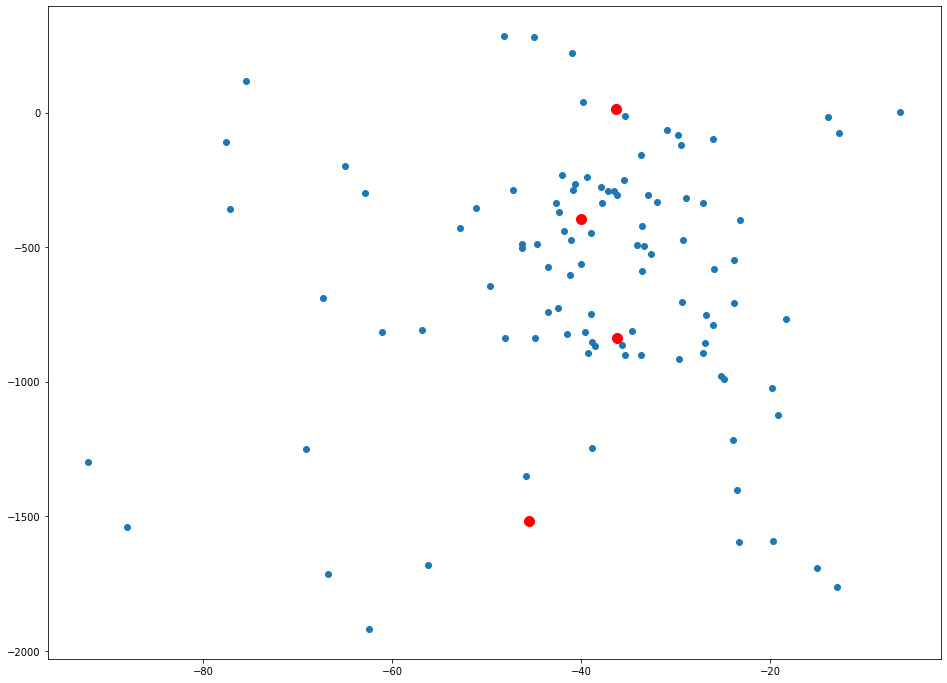

In [163]:
from sklearn.cluster import KMeans
model = KMeans(4)
X = []
locs = []
for loc, ((a, b, c), s) in result.items():
    if (c / a > -2000):
        X.append((b / (2 * a), c / a))
        locs.append(loc)
X = np.array(X)

model.fit(X)
plt.figure(figsize=(16,12))
plt.scatter(X[:,0],X[:,1]);
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, color="red"); # Show the centres

In [165]:
clusters = list(zip(model.predict(X), locs))
for i in range(4):
    print(f'Cluster {i}:')
    for c in clusters:
        if c[0] == i:
            print(c[1])
    print('---------')

Cluster 0:
Afghanistan
Burkina Faso
Bermuda
Colombia
Egypt
Guernsey
Ghana
Indonesia
Libya
Luxembourg
Montenegro
Palestine
Saudi Arabia
South Africa
---------
Cluster 1:
Azerbaijan
Belgium
Brazil
Switzerland
Congo
Cuba
Czech Republic
Dominican Republic
Algeria
Ecuador
Spain
Estonia
Finland
Georgia
Guinea
Equatorial Guinea
Greece
Hungary
India
Ireland
Iraq
Iceland
Jamaica
Moldova
Macedonia
Mali
Myanmar
Niger
Netherlands
Norway
Oman
Poland
Portugal
Romania
Russia
Serbia
Sweden
Tunisia
Ukraine
Uzbekistan
---------
Cluster 2:
Albania
Argentina
Bosnia and Herzegovina
Chile
Cote d'Ivoire
Cameroon
Costa Rica
Cyprus
Denmark
Isle of Man
Iran
Italy
Jersey
Kazakhstan
Kyrgyzstan
Lebanon
Liberia
Lithuania
Latvia
Morocco
Mexico
Malta
New Zealand
Pakistan
Panama
Peru
Philippines
Slovakia
Slovenia
Turkey
---------
Cluster 3:
Austria
Bangladesh
Belarus
China
Djibouti
Croatia
Israel
South Korea
Kosovo
Somalia
Sao Tome and Principe
Tajikistan
Tanzania
World
International
---------


Я попробовал выделить полный квадрад в обученной модели, чтобы чисто визуально можно рассмотреть распределение по кластерам как пологость захода на "экспоненту". Какие то четкие кластеры выделить невозможно, тем более что нужно явно подбирать даты чтобы параметры модели были сравнимы.

Примеры из первого кластера 

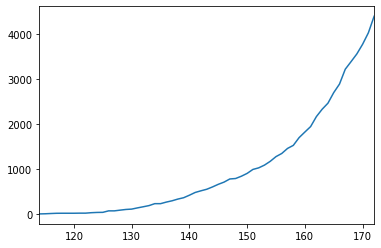

In [175]:
data['Afghanistan'][1].total_cases.plot()

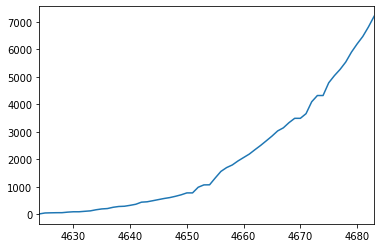

In [176]:
data['Egypt'][1].total_cases.plot()

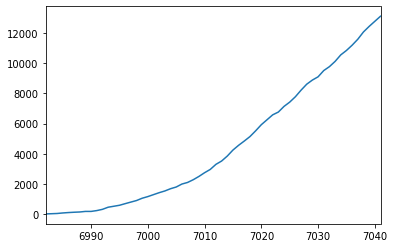

In [178]:
data['Indonesia'][1].total_cases.plot()

Примеры из второго кластера:

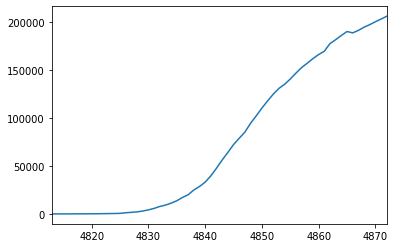

In [180]:
data['Spain'][1].total_cases.plot()

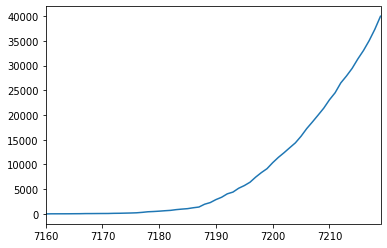

In [181]:
data['India'][1].total_cases.plot()

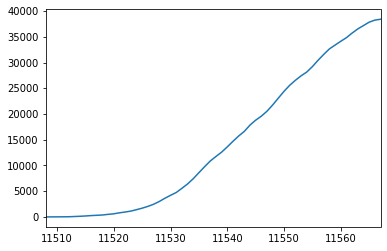

In [182]:
data['Netherlands'][1].total_cases.plot()

Примеры из третьего кластера:

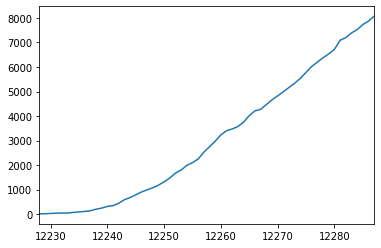

In [184]:
data['Panama'][1].total_cases.plot()

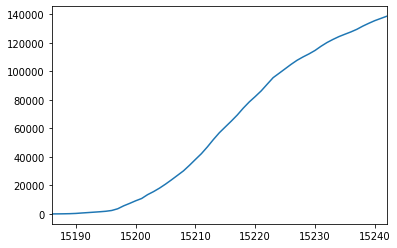

In [185]:
data['Turkey'][1].total_cases.plot()

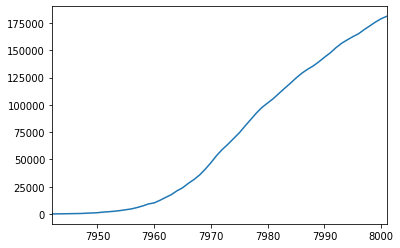

In [186]:
data['Italy'][1].total_cases.plot()

Примеры из четвертого кластера:

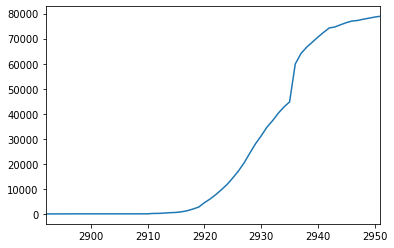

In [187]:
data['China'][1].total_cases.plot()

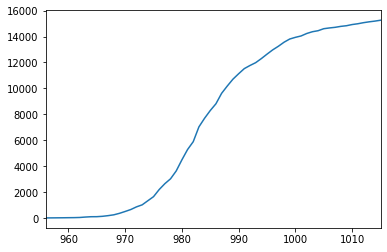

In [190]:
data['Austria'][1].total_cases.plot()

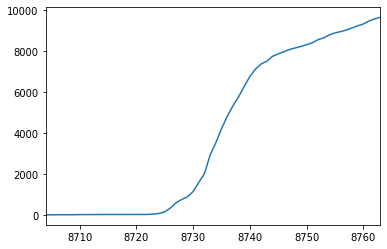

In [189]:
data['South Korea'][1].total_cases.plot()